<a href="https://colab.research.google.com/github/AAleksandros/decision_making_project/blob/main/Copy_of_Decision_making_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Εργασία στα Συστήματα Λήψης Αποφάσεων

Ομάδες 3 ατόμων deadline: 18/6/2023

Στην παρούσα εργασία θα διαχειριστούμε και θα αναλύσουμε open και synthetic data για να εξάγουμε συμπεράσματα, να κάνουμε συστάσεις και να πάρουμε αποφάσεις για την επιλογή μουσικών συγκροτημάτων, καθώς και την αγορά/πώληση δίσκων. Για την εξαγωγή των opendata θα χρησιμοποιήσουμε το [Last.fm](https://www.last.fm/api) Music Discovery API [1] και/ή το [discogs API](https://www.discogs.com/developers) [2]

[1] https://www.last.fm/api

[2] https://www.discogs.com/developers


Required modules installation.

In [ ]:
!pip install mysql.connector
!pip install names
!pip install statsmodels
!pip install pmdarima
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 58.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp310-cp310-linux_x86_64.whl size=247953 sha256=921b3a2ae8d3be2020dab2bc626de3c5cc37f1660f9427db761ba3d946e5019d
  Stored in directory: /root/.cache/pip/wheels/76/48/9b/da67ff1a18fe8e9d428f9b1a177716d4a7d363d2bbe83bf6cf
Successfully built mysql.connector
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.1/789.1 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803682 sha256=23a8d3203cef542938bce18eae7d0ae8bfefd3f3b6375ad2f7efd8c09df59354
  Stored in directory: /root/.cache/pip/wheels/fc/9a/6f/78f4282bbcaa2d8c678b73c54c0bb1b7a04009f0d7cec79fce
Successfully built names
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 4.5 MB/s eta 

Imports.

In [ ]:
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from deap import creator, base, tools, algorithms
from math import sqrt
import networkx as nx
import numpy as np
import pandas as pd
import json
import math
import random
import names
import requests
import time
import socket
import seaborn as sns
import mysql.connector
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Configuration file for secure storage of sensitive information.

In [ ]:
# Read and retrieve the data from the configuration file.
with open('/content/gdrive/My Drive/config_data.json', 'r') as f:
    config_data = json.load(f)

db_host = config_data['DB_HOST']
db_port = config_data['DB_PORT']
db_user = config_data['DB_USER']
db_password = config_data['DB_PASSWORD']
db_database = config_data['DB_DATABASE']
lastfm_api_key = config_data['LASTFM_API_KEY']
discogs_api_token = config_data['DISCOGS_API_TOKEN']

Connectivity test from google colab to mydb in docker desktop mariadb container

In [ ]:
try:
    # Create a socket object.
    sock = socket.create_connection((db_host, db_port), timeout=5)

    # If the connection succeeds, print a success message.
    print(f"Successfully connected to {db_host}:{db_port}")

    # Close the socket connection.
    sock.close()

except Exception as e:
    # If there is an error, print the error message.
    print(f"Error: {e}")

Successfully connected to 46.246.177.50:3306


Queries to create the required relational database schema.

In [ ]:
mydb = mysql.connector.connect(
    host=db_host,
    port=db_port,
    user=db_user,
    password=db_password,
    database=db_database
)
cursor = mydb.cursor()

cursor.execute("CREATE TABLE Users (user_id INT(11) NOT NULL AUTO_INCREMENT PRIMARY KEY, name VARCHAR(255));")
cursor.execute("CREATE TABLE Bands (band_id INT(11) NOT NULL AUTO_INCREMENT PRIMARY KEY, name VARCHAR(255), genre VARCHAR(255), playcount INT(11), listeners INT(11), entry_timestamp TIMESTAMP);")
cursor.execute("CREATE TABLE Records (record_id INT(11) NOT NULL AUTO_INCREMENT PRIMARY KEY, name VARCHAR(255), band_id INT(11), price FLOAT, FOREIGN KEY (band_id) REFERENCES Bands(band_id));")
cursor.execute("CREATE TABLE User_Bands (user_id INT(11) NOT NULL, band_id INT(11) NOT NULL, PRIMARY KEY (user_id, band_id), FOREIGN KEY (user_id) REFERENCES Users(user_id), FOREIGN KEY (band_id) REFERENCES Bands(band_id));")
cursor.execute("CREATE TABLE User_Records (user_id INT(11) NOT NULL, record_id INT(11) NOT NULL, PRIMARY KEY (user_id, record_id), FOREIGN KEY (user_id) REFERENCES Users(user_id), FOREIGN KEY (record_id) REFERENCES Records(record_id));")

mydb.commit()
cursor.close()
mydb.close()

NameError: ignored

- Η βάση δεδομένων που δημιουργήθηκε είναι μια **σχεσιακή βάση**. Μια τέτοια βάση είναι καλή επιλογή λόγω της δομημένες λογικής της και ικανότητα της να χειρίζεται περίπλοκες σχέσεις μεταξύ οντοτήτων δεδομένων.

- Προσφέρει **ακεραιότητα δεδομένων** καθώς επιβάλλονται περιορισμοί μέσω των **πρωτεύοντων και ξένων κλειδιών**, διασφαλίζοντας την ακρίβεια και την συνέπεια των δεδομένων.

- Επιπροσθέτως, διευκολύνεται η διαχείριση σχέσεων μεταξύ των πινάκων και η ανάκτηση σχετικών δεδομένων.

- Σημαντικό επίσης, πως οι σχεσιακές βάσεις είναι εξαιρετικά διαδεδομένες οπότε και παρέχονται εύκολα πολλά εργαλεία και βιβλιοθήκες.

**Έστω ότι έχετε 20 users που σχηματίζουν ένα community όπως δίνεται από ένα Barabasi Albert model [3].**

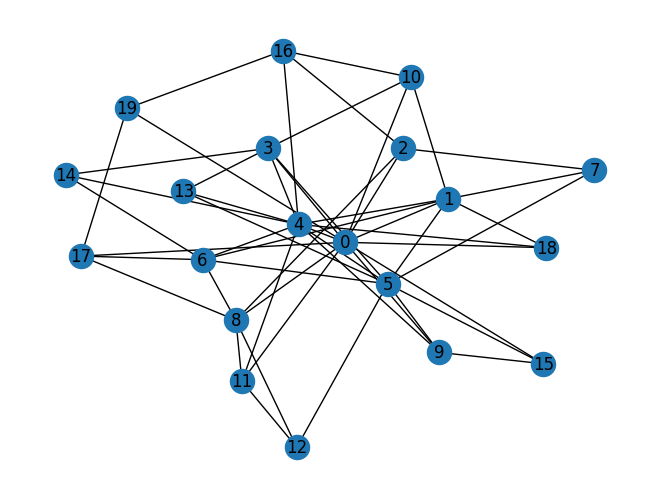

In [ ]:
community_graph= nx.barabasi_albert_graph(20,3)
nx.draw(community_graph, with_labels=True)


**(α.) Σχεδιάστε το data model που θα αναπαριστά τους users του community, τα συγκροτήματα που τους αρέσουν καθώς και τους δίσκους που έχουν. Υλοποιήστε το scheme του data model σε μια σχεσιακή (SQL like) βάση δεδομένων (ΒΔ) και φτιάξτε συναρτήσεις που εισάγουν τυχαία δεδομένα της επιλογής σας για τους users. [Διάλεξη 3 MySQL]**

In [ ]:
mydb = mysql.connector.connect(
    host=db_host,
    port=db_port,
    user=db_user,
    password=db_password,
    database=db_database
)

cursor = mydb.cursor()

# Define a function to insert a user.
def insert_user(name):
    add_user = ("INSERT INTO Users (name) VALUES (%s)")
    cursor.execute(add_user, (name,))

# Check the number of users in the table and then, if the user count is already 20, print a message and skip the insertion.
cursor.execute("SELECT COUNT(*) FROM Users")
user_count = cursor.fetchone()[0]

if user_count >= 20:
    print("User table is already full.")
else:
    for _ in range(20):
        insert_user(names.get_full_name())
    mydb.commit()

mydb.close()

User table is already full.


**(β.) Για τον κάθε user του community φτιαξτε συναρτήσεις που να ανακτούν δεδομένα από τα opendata σε σχέση με τα συγκροτήματα που ακούει και τους δίσκους που τον ενδιαφέρουν και να γεμίζουν τα αντίστοιχα tables στην ΒΔ. [Rest calls στα [1] [2] και Διάλεξη 3 MySQL]**

**Σημείωση: Για την επιλογή των attributes λάβετε υπόψη σας τα επόμενα ερωτήματα. Είναι φυσικό καθώς εξοικειώνεστε με την εργασία να αλλάζετε το σχήμα της ΒΔ και τα attributes). **

[1] https://www.last.fm/api

[2] https://www.discogs.com/developers

In [ ]:
mydb = mysql.connector.connect(
    host=db_host,
    port=db_port,
    user=db_user,
    password=db_password,
    database=db_database
)

cursor = mydb.cursor()

# Get the top artists from the Last.fm API.
response = requests.get('http://ws.audioscrobbler.com/2.0/?method=chart.gettopartists&api_key=' + lastfm_api_key + '&format=json')
top_artists = response.json()['artists']['artist']
# Wait for 1 second to avoid hitting the API rate limit.
time.sleep(1)

# Get the user IDs from the database.
cursor.execute("SELECT user_id FROM Users")
user_ids = [row[0] for row in cursor.fetchall()]

# Define the order of record quality preference.
price_preference_order = ['Very Good Plus (VG+)', 'Near Mint (NM or M-)', 'Mint (M)', 'Very Good (VG)', 'Good Plus (G+)', 'Good (G)', 'Fair (F)', 'Poor (P)']

for user_id in user_ids:
    # Check if the user already has at least 2 artists linked to them.
    cursor.execute("SELECT COUNT(*) FROM User_Bands WHERE user_id = %s", (user_id,))
    count = cursor.fetchone()[0]
    if count >= 2:
        print("User " + str(user_id) + " already has at least 2 artists linked to them. Skipping user...")
        continue
    # Randomly assign 2 to 5 artists to the user.
    liked_artists = random.sample(top_artists, random.randint(2, 5))
    for artist in liked_artists:
        # Check if the artist is already in the Bands table.
        cursor.execute("SELECT band_id FROM Bands WHERE name = %s", (artist['name'],))
        result = cursor.fetchone()
        if result is None:
            # Get genre information for the artist, insert the artist into the Bands table and then get the ID of the newly inserted band.
            response = requests.get('http://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist=' + artist['name'] + '&api_key=' + lastfm_api_key + '&format=json')
            artist_info = response.json()
            genre = artist_info['artist']['tags']['tag'][0]['name'] if artist_info['artist']['tags']['tag'] else None
            cursor.execute("INSERT INTO Bands (name, genre) VALUES (%s, %s)", (artist['name'], genre))
            mydb.commit()
            band_id = cursor.lastrowid
            time.sleep(1)
        else:
            print("Artist or band " + artist['name'] + " with id " + str(band_id) + " is already present in the Bands table. Skipping artist/band...")
            band_id = result[0]

        # Link the user and the band in the User_Bands table if not already linked.
        cursor.execute("SELECT * FROM User_Bands WHERE user_id = %s AND band_id = %s", (user_id, band_id))
        if cursor.fetchone() is None:
            cursor.execute("INSERT INTO User_Bands (user_id, band_id) VALUES (%s, %s)", (user_id, band_id))
            mydb.commit()
        else:
           print("User " + str(user_id) + " and artist/band " + artist['name'] + " with id " + str(band_id) + " are already linked. Skipping link creation...")


        # Use the Discogs API to get the albums of the artist and then create a list to use later in album assignment.
        response = requests.get('https://api.discogs.com/database/search?type=release&artist=' + artist['name'] + '&token=' + discogs_api_token)
        albums = response.json()['results']
        time.sleep(1)
        owned_albums = random.sample(albums, random.randint(1, min(5, len(albums))))

        for album in owned_albums:
            # Check if the user already has at least one record linked to them that belongs to the current artist.
            cursor.execute("SELECT COUNT(*) FROM User_Records JOIN Records ON User_Records.record_id = Records.record_id WHERE User_Records.user_id = %s AND Records.band_id = %s", (user_id, band_id))
            count = cursor.fetchone()[0]
            if count > 0:
                print("User " + str(user_id) + " already has at least one record linked to them belonging to current artist/band " + str(band_id) + ". Skipping link creation...")
                continue

            # Check if the album is already in the Records table.
            cursor.execute("SELECT record_id FROM Records WHERE name = %s AND band_id = %s", (album['title'], band_id))
            result = cursor.fetchone()
            if result is None:
                # Get the price suggestions for the album from the Discogs API and then iterate over the conditions in the order of preference.
                response = requests.get('https://api.discogs.com/marketplace/price_suggestions/' + str(album['id']), headers={'Authorization': 'Discogs token=' + discogs_api_token})
                price_suggestions = response.json()
                price = None

                for condition in price_preference_order:
                    # If the condition is in the price suggestions, get the price and break the loop.
                    if condition in price_suggestions:
                        price = price_suggestions[condition]['value']
                        break

                # Insert the album into the Records table and get the ID of the newly inserted record.
                cursor.execute("INSERT INTO Records (name, band_id, price) VALUES (%s, %s, %s)", (album['title'], band_id, price))
                mydb.commit()
                record_id = cursor.lastrowid
                time.sleep(1)
            else:
                print(" Record " + album['title'] + " already present in records table. Skipping insertion...")
                record_id = result[0]

            # Link the user and the album in the User_Records table if not already linked.
            cursor.execute("SELECT * FROM User_Records WHERE user_id = %s AND record_id = %s", (user_id, record_id))
            if cursor.fetchone() is None:
                cursor.execute("INSERT INTO User_Records (user_id, record_id) VALUES (%s, %s)", (user_id, record_id))
                mydb.commit()
            else:
              print("User " + str(user_id) + " and record " + str(record_id) + " already linked. Skipping link creation...")

User 1 already has at least 2 artists linked to them. Skipping user...
User 2 already has at least 2 artists linked to them. Skipping user...
User 3 already has at least 2 artists linked to them. Skipping user...
User 4 already has at least 2 artists linked to them. Skipping user...
User 5 already has at least 2 artists linked to them. Skipping user...
User 6 already has at least 2 artists linked to them. Skipping user...
User 7 already has at least 2 artists linked to them. Skipping user...
User 8 already has at least 2 artists linked to them. Skipping user...
User 9 already has at least 2 artists linked to them. Skipping user...
User 10 already has at least 2 artists linked to them. Skipping user...
User 11 already has at least 2 artists linked to them. Skipping user...
User 12 already has at least 2 artists linked to them. Skipping user...
User 13 already has at least 2 artists linked to them. Skipping user...
User 14 already has at least 2 artists linked to them. Skipping user...
U

- Ο παραπάνω κώδικας συμπλήρωσης δεδόμενων, αναπτύχθηκε ώστε να αποθηκευτούν οι απαραίτητες πληροφορίες που σχετίζονται με χρήστες, συγκροτήματα/καλλιτέχνες, δίσκους/άλμπουμ και τις σχέσεις τους.

- Αναλυτικότερα, γίνεται ανάκτηση των κορυφαίων καλλιτεχνών από το **Last.fm API **όπου αυτά τα δεδομένα θα χρησιμοποιηθούν για την τυχαία ανάθεση καλλιτεχνών σε χρήστες.

- Εκτελόντας διάφορα SQL querys, αποκτάμε και αποθηκεύουμε πληροφορίες για bands/artists και τα συνδέουμε με χρήστες. Μέσω genetic algorithm selection, επιλέγουμε τυχαία ένα υποσύνολο καλλιτεχνών για κάθε χρήστη, ελέγχοντας για ήδη υπάρχων links, καθώς λόγω περιορισμένων υπολογιστηκών πόρων, έχουν μπει μερικά συγκεκριμένα όρια. Βέβαια, αυτό επιτυγχάνει και μια τυχαία **ποικιλομορφία** στα "γούστα" των χρηστών, προσφέροντας **ρεαλισμό**.

- Έπειτα, μέσω του **Discogs API** γίνεται ανάκτηση των άλμπουμ και προτάσεις τιμών τους για κάθε επιλεγμένο καλλιτέχνη.

- Καθόλη την διάρκεια σχεδιασμού του προγράμματος, ο κώδικας αναπτύχθηκε με γνώμονα μια συστηματική προσέγγιση για τη **διασφάλιση της ακεραιότητας των σχέσεων των δεδομένων** και **αποφυγή επικαλύψεις ή ασυνέπειας**.

- Καταλήγοντας, έγινε προσπάθεια ο κώδικας να δείχνει μια **στοχαστική προσέγγιση** για τη συμπλήρωση μιας βάσης δεδομένων με ρεαλιστικά δεδομένα, ενσωματώνοντας εξωτερικά δεδομένα API, χρησιμοποιώντας **γενετικούς αλγόριθμους** για επιλογή και καθιερώνοντας κατάλληλες σχέσεις μεταξύ οντοτήτων. Επιπλέον, δώθηκε προσοχή στην **διασφάλιση της ακεραιότητα των δεδομένων**, ενσωματώνοντας εξωτερικές πηγές δεδομένων και δημιουργώντας ουσιαστικές σχέσεις μέσα στη βάση δεδομένων.



**(γ.) Υλοποιήστε μια συνάρτηση που να κάνει έλεγχο και να αντιμετωπίζει [missing]**(https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b) [4], [duplicate](https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python) [5] ή [outlier](https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623) [6] **values σε κάποιο από τα attributes της ΒΔ.**

[4] https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b

[5] https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python

[6] https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623

In [ ]:
mydb = mysql.connector.connect(
    host=db_host,
    port=db_port,
    user=db_user,
    password=db_password,
    database=db_database
)

cursor = mydb.cursor()

# Calculate the average price of all records and get all records with NULL price.
cursor.execute("SELECT AVG(price) FROM Records WHERE price IS NOT NULL")
average_price = cursor.fetchone()[0]
cursor.execute("SELECT record_id FROM Records WHERE price IS NULL")
records = cursor.fetchall()

null_prices_updated = 0

for record in records:
    record_id = record[0]

    # Generate a random percentage between -25% and +25%, calculate the new price and then update the price in the Records table.
    percentage = random.uniform(-0.25, 0.25)
    new_price = average_price * (1 + percentage)
    cursor.execute("UPDATE Records SET price = %s WHERE record_id = %s", (new_price, record_id))
    mydb.commit()
    null_prices_updated += 1

print("Number of null prices updated:", null_prices_updated)

Number of null prices updated: 0


- Ο κώδικας εισαγωγής δεδομένων στο ερώτημα (β), αναπτύχθηκε με γνώμονα την **αποφυγή δημιουργίας duplicates και missing values**. Για αυτόν τον λόγο, το μόνο attribute της βάσης δεδομένων που χρειάστηκε έλεγχο και αντιμετώπιση (data cleaning), ήταν αυτό της **τιμής των δίσκων στο table Records**.

- Η τεχνική που χρησιμοποιήθηκε για να αντικατασταθούν οι missing τιμές, ήταν να υπολογισθεί ο μέσος όρος της τιμής όλων των records και έπειτα να προστεθεί ένα στοιχείο τυχαιότητας για κάθε τιμή από **-25% εώς +25%**.

- Ο σκοπός ήταν η τεχνική να είναι σχετικά απλή, καθώς δεν έγινε δυνατό να εντοπισθεί εναλλακτικός τρόπος να αποκτηθούν αληθινές τιμές για τα εν λόγο records.

- Παρόλαυτα, γίνονται αντιλυπτές τυχών επιπτώσεις που μπορεί να επιφέρει αυτή η κίνηση αλλά και ευκαιρίες για να παρατηρηθούν τα **αποτελέσματα στην συνολική κατανομή των τιμών**, επιτρέποντας μας να κατανοηθούν οι τρόποι που αυτοί **οι παράγοντες την επηρεάζουν**

- Για παράδειγμα, τα τυχαία δεδομένα αυτά, μπορούν να χρησιμοποιηθούν ώς εργαλείο, ώστε να προσομοιωθούν διάφορα σενάρια, όπως να εκτελεσθούν πολλές επαναλήψεις με **διαφορετικές τυχαίες παραλλαγές** και να παρατηρηθεί το εύρος των πιθανών αποτελεσμάτων. Αυτή η διαδικασία εξερεύνησης προσομοιώσεων μας επιτρέπει να αναλύσουμε **το αντίκτυπο των τυχαίων δεδομένων στην λήψη αποφάσεων**.

- Καταλήγοντας, η απόφαση αυτή είναι **συνειδητή** και υπάρχει πλήρης επίγνωση για τις πιθανές επιπτώσεις, τους περιορισμούς και τις προκλήσεις που σχετίζονται με αυτήν την προσέγγιση. Παρόλαυτα, θα κινηθούμε με **κριτική ανάλυση και επιμέλεια** σε αυτήν την διαδικασία λήψης αποφάσεων.

**(δ.) Βγάλτε κάποια στατιστικά συμπεράσματα για τα data features [7] [8]**

[7] https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html

[8] https://sparkbyexamples.com/pandas/calculate-summary-statistics-in-pandas/

In [ ]:
mydb = mysql.connector.connect(
    host=db_host,
    port=db_port,
    user=db_user,
    password=db_password,
    database=db_database
)

cursor = mydb.cursor()

# Execute the SQL query
cursor.execute("""
    SELECT Bands.genre, COUNT(DISTINCT User_Bands.user_id) as user_count
    FROM User_Bands
    JOIN Bands ON User_Bands.band_id = Bands.band_id
    GROUP BY Bands.genre
    ORDER BY user_count DESC
""")

rows1 = cursor.fetchall()
for row in rows1:
    print("Genre: ", row[0], ", Number of Users: ", row[1])

Genre:  pop , Number of Users:  15
Genre:  Hip-Hop , Number of Users:  10
Genre:  rnb , Number of Users:  7
Genre:  classic rock , Number of Users:  5
Genre:  rap , Number of Users:  5
Genre:  country , Number of Users:  4
Genre:  female vocalists , Number of Users:  3
Genre:  indie , Number of Users:  3
Genre:  Lo-Fi , Number of Users:  3
Genre:  rock , Number of Users:  3
Genre:  trap , Number of Users:  3
Genre:  alternative , Number of Users:  2
Genre:  indie rock , Number of Users:  2
Genre:  jazz , Number of Users:  1
Genre:  seen live , Number of Users:  1
Genre:  soul , Number of Users:  1


- Παραπάνω έχουμε μια λίστα από προτιμήσεις κατηγοριών μουσικής κατανεμημένα από **το διασημότερο στο λιγότερο αγαπητό**. Μπορούμε να δούμε πως έχουμε μερικά προφανή διάσημα και προτιμητέα είδη μουσικής μεταξύ των 20 χρηστών μας.

- Η διασημότητα της μουσικής **"pop"**, με 15 από τους 20 χρήστες να την προτιμούν είναι ξεκάθαρη. Βεβαίως έπειτα ακολουθούν το **"hip-hop"** με 10 χρήστες και **"rnb"** με 7 χρήστες το καθένα. Μόνο από αυτές τις τρεις τιμές, διεξάγουμε εύκολα το συμπέρασμα πως οι χρήστες τυχαίνει να προτιμούν **"mainstream"** μουσική.

- Παρόλαυτα, παρατηρούμε πως υπάρχει ένα εύρος προτιμήσεων με 16 διαφορετικά είδη μουσικής. Αυτό δείχνει πως οι χρήστες μας **έχουν ποικιλία στα ακούσματα τους**.

- Στη συνέχεια, μας γίνεται ένδειξη πως ενώ μερικά είδη είναι πολύ διάσημα, αρκετά αντιθέτως γίνονται αρεστά μόνο από μερικούς χρήστες, όπως το **"jazz"** και **"soul"**, όπου για παράδειγμα επιλέγονται από μόνο ένα χρήστη το καθένα. Αυτό ενδεικνύει ένα λεγόμενο **"Long-tail distribution"**, το οποίο σαν φαινόμενο, είναι συχνό σε πολλές διαστάσεις σχετικά με τα ψηφιακά μέσα.

---
Σε επόμενη φάση διεξαγωγής στατιστικών συμπερασμάτων έχουμε σκοπό να εντοπίσουμε την επικάλυψη των ειδών μεταξύ των χρηστών. Δηλαδή, πόσοι χρήστες που τους αρέσει ένα είδος μουσικής, τους αρέσει και ένα άλλο, δημιουργόντας μια επικάλυψη, και κατά αυτόν τον τρόπο **να δούμε πόσο συχνά είναι για παράδειγμα κοινές οι προτιμήσεις των χρηστών.**

In [ ]:
mydb = mysql.connector.connect(
    host=db_host,
    port=db_port,
    user=db_user,
    password=db_password,
    database=db_database
)

cursor = mydb.cursor()

# Fetch the data from the database, convert rows2 to a dataframe,  drop duplicates from the dataframe and create a matrix where each cell represents the number of users who like both genres.
cursor.execute("""
    SELECT Users.user_id, Bands.genre
    FROM Users
    JOIN User_Bands ON Users.user_id = User_Bands.user_id
    JOIN Bands ON User_Bands.band_id = Bands.band_id
""")
rows2 = cursor.fetchall()

df = pd.DataFrame(rows2, columns=['user_id', 'genre'])
df = df.drop_duplicates()

user_genre_matrix = df.pivot_table(index='user_id', columns='genre', aggfunc='size', fill_value=0)
co_occurrence_matrix = user_genre_matrix.T.dot(user_genre_matrix)

print(co_occurrence_matrix)

genre             Hip-Hop  Lo-Fi  alternative  classic rock  country  \
genre                                                                  
Hip-Hop                10      2            0             1        3   
Lo-Fi                   2      3            0             0        0   
alternative             0      0            2             2        0   
classic rock            1      0            2             5        0   
country                 3      0            0             0        4   
female vocalists        3      0            0             0        1   
indie                   1      1            0             0        0   
indie rock              1      2            0             0        0   
jazz                    1      1            0             0        0   
pop                     7      1            1             3        4   
rap                     3      1            1             1        3   
rnb                     4      1            0             0     

---
Δημιουργία των νέων columns για την αποθήκευση νέων δεδομένων σχετικά με το playcount, listeners και το timestamp την στιγμή της εισαγωγής των δεδομένων του κάθε καλλιτέχνη/μπάντας στο table Bands.

In [ ]:
mydb = mysql.connector.connect(
    host=db_host,
    port=db_port,
    user=db_user,
    password=db_password,
    database=db_database
)

cursor = mydb.cursor()

#Adjust the Records table to accept new data about playcount, listeners of each record and also provide a timestamp.

cursor.execute("ALTER TABLE Bands ADD COLUMN playcount INT")
cursor.execute("ALTER TABLE Bands ADD COLUMN listeners INT")
cursor.execute("ALTER TABLE Bands ADD COLUMN entry_timestamp TIMESTAMP")
mydb.commit()

Έπειτα θα κάνουμε **fetch** τα νέα αυτά δεδομένα **για κάθε band και τα αποθηκεύουμε στο Bands table.**

In [ ]:
mydb = mysql.connector.connect(
    host=db_host,
    port=db_port,
    user=db_user,
    password=db_password,
    database=db_database
)

cursor = mydb.cursor()

cursor.execute("SELECT band_id, name FROM Bands")
bands = cursor.fetchall()

for band in bands:
    response = requests.get('http://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist=' + band[1] + '&api_key=' + lastfm_api_key + '&format=json')
    artist_info = response.json()
    playcount = artist_info['artist']['stats']['playcount']
    listeners = artist_info['artist']['stats']['listeners']
    time.sleep(1)

    cursor.execute("UPDATE Bands SET playcount = %s, listeners = %s, entry_timestamp = NOW() WHERE band_id = %s", (playcount, listeners, band[0]))
    mydb.commit()

Έν τέλει θα υπολογίσουμε το συνολικό αριθμό από **playcount και listeners ανά κατηγορία μουσικής**. Επιπλέον θα υπολογίσουμε την **αναλογία playcount / listenerers μιάς και χρήζει στατιστικής σημασίας.**

In [ ]:
mydb = mysql.connector.connect(
    host=db_host,
    port=db_port,
    user=db_user,
    password=db_password,
    database=db_database
)

cursor = mydb.cursor()

cursor.execute("SELECT genre FROM Bands GROUP BY genre")
genres = cursor.fetchall()

for genre in genres:
    cursor.execute("SELECT SUM(playcount), SUM(listeners) FROM Bands WHERE genre = %s", (genre[0],))
    sums = cursor.fetchone()
    if sums[1] != 0:
        ratio = sums[0] / sums[1]
    else:
        ratio = 0
    print("Genre: " + genre[0] + ", Total Playcount: " + str(sums[0]) + ", Total Listeners: " + str(sums[1]) + ", Playcount-to-Listeners Ratio: " + str(ratio))

Genre: alternative, Total Playcount: 297557950, Total Listeners: 4988801, Playcount-to-Listeners Ratio: 59.64518328151393491141458639
Genre: classic rock, Total Playcount: 838451567, Total Listeners: 8188696, Playcount-to-Listeners Ratio: 102.3913413075781540797216065
Genre: country, Total Playcount: 1434258940, Total Listeners: 4045068, Playcount-to-Listeners Ratio: 354.5697970961180380651202897
Genre: female vocalists, Total Playcount: 674394267, Total Listeners: 3474646, Playcount-to-Listeners Ratio: 194.0900647145061683981619998
Genre: Hip-Hop, Total Playcount: 2046327560, Total Listeners: 17422443, Playcount-to-Listeners Ratio: 117.4535373713089490377440179
Genre: indie, Total Playcount: 268698295, Total Listeners: 3354749, Playcount-to-Listeners Ratio: 80.09490277812140341945105282
Genre: indie rock, Total Playcount: 547179148, Total Listeners: 5097812, Playcount-to-Listeners Ratio: 107.3360783018283137942317214
Genre: jazz, Total Playcount: 108375898, Total Listeners: 1549393, P

---

**Με τα παραπάνω αποτελέσματα μπορούμε να διεξάγουμε ορισμένα στατιστικά συμπεράσματα για τα έν λόγο data features σχετικά με τα playcount και listeners ανά genre μουσικής.**

- Δεδομένου ότι στο table Bands εισάχθηκαν καλλιτέχνες/μπάντες με την μέθοδο chart.getTopArtists που μας επιστρέφει τα **top artists charts του last.fm** την δεδομένη στιγμή εκτέλεσης του κώδικα, μας δίνεται η δυνατότητα να δούμε πόσοι μοναδικοί χρήστες έχουν προτιμήσει τον κάθε καλλιτέχνη/μπάντα** τουλάχιστον μία φορά**, αλλά και σε **βάθος χρόνου μέσω του playcount** που μας δείχνει τις **συνολικές φορές** που έχει αναπαραχθεί ένα μουσικό κομμάτι ενός καλλιτέχνη/μπάντας.

- Αρχικά, θα παρατηρήσουμε πως οι κατηγορίες **"Pop", "Hip-Hop" και "Rnb"** έχουν και **υψηλό playcount **αλλά και **υψηλό listeners αριθμό**. Αυτό μας υποδηλώνει πως ανάμεσα των χρηστών του last.fm αυτές οι τρεις κατηγορίες είναι **εξαιρετικά διάσημες.**

- Αντιθέτως, τα genres **"Trap", "Seen Live", "Jazz" και "Soul"** έχουν συγκριτικά αρκετά μικρότερο αριθμό playcount και listeners. Αυτό πιθανότατα υποδηλώνει πως τα συγκεκριμένα genres τείνουν να είναι πιο **"άγνωστα" ή λιγότερο προτεινόμενα από τους χρήστες του last.fm.**

- Στη συνέχεια, μία επιπρόσθετη παρατήρηση που εντοπίζεται, είναι το γεγονός πως μερικά genres όπως το **"Classic Rock" και "Indie Rock"** έχουν υψηλό playcount αλλά σχετικά χαμηλό listener count σε σύγκριση με την **"Pop" ή "Hip-Hop".** Αυτό υποδηλώνει μία τάση των χρηστών που προτιμούν τα δύο προαναφερόμενα genres, **να συνεχίζουν να απολαμβάνουν αυτούς τους καλλιτέχνες διαχρονικά.**

- Λαμβάνοντας υπόψην πλέον και τα αποτελέσματα των αναλογιών** playcount προς listeners**, έχουμε την δυνατότητα να διεξάγουμε επιπλέον συμπεράσματα.

- Πρώτον, παρατηρούμε ένα **διπολικό φαινόμενο ειδών μουσικής** με υψηλή και χαμηλή απασχόληση ή αλλιώς **engagement.** Αναλυτικότερα, έχουμε **high engagement genres, όπως "Country", "Female Vocalist" και "Seen Live"** όπου έχουν υψηλή αναλογία playcount προς listeners. Αυτό μας ωθεί στο συμπέρασμα πως αυτοί οι ακροατές τείνουν να αναπαράγουν την μουσική αυτού του είδους συχνά, **γεγονός που υποδηλώνει πιθανότατα ένα πιστό "fanbase".**

- Σε αντίθεση βρίσκονται τα genres **"Alternative", "Rap" και "Rock"** με χαμηλή αναλογία playcount προς listeners ή αλλιώς, low engagement genres. Το γεγονός αυτό ίσως να μας υποδεικνύει πως παρότι υπάρχει ένας **σημαντικός αριθμός μοναδικών χρηστών** που έχουν αναπαράξει μουσικό υλικό του καλλιτέχνη/μπάντας, **πιθανότατα δεν τείνουν να μετατρέπονται σε συχνοί ακροατές.**

- Θα ήταν λάθος να προσπεράσουμε και το φαινόμενο του genre **"Pop"**. Παρατηρείται πώς παρότι έχει το μεγαλύτερο αριθμό playcount και listeners, **δεν** έχει την μεγαλύτερη προαναφερόμενη αναλογία. Με λίγα λόγια, στην ειδική αυτή περίπτωση, λαμβάνουμε την ιδέα πως **η δημοτικότητα δεν συμπίπτει απαραίτητα με την διακράτηση αφοσιωμένων ακροατών από την άποψη των επαναλαμβανόμενων ακροάσεων.**

- Ένα συμπέρασμα που θα μπορούσε να αντληθεί είναι πως τα είδη μουσικής με χαμηλή αναλογία playcount προς listeners, ίσως να επιτυγχάνανε αύξηση των συνολικών αναπαραγωγών τους, με την εφαρμογή διαφόρων ειδών στρατηγικής όπως **κυκλοφορία νέας μουσικής σε μεγαλύτερη συχνότητα, καμπάνιες διαφημιστικές και μεγαλύτερη συνδιαλεκτικότητα με τους θαυμαστές τους στα μέσα κοινωνικής δικτύωσης.**

- Επιπροσθέτως, παρατηρείται και κάτι σχετικά προφανές. Υπάρχει αυξημένη μεταβλητότητα των δεδομένων. Αναλυτικότερα, **η αναλογία playcount προς listeners διαφέρει ραγδαία ανά είδος μουσικής.**

- Ώς μία **ελαφριά** "αποποίηση ευθυνών", τα παραπάνω συμπεράσματα, παραμένουν φυσικά πλήρως βασισμένα στα δεδομένα που καταφέραμε να αντλήσουμε από το Last.fm και τους συγκεκριμένους καλλιτέχνες/μπάντες που αντιπροσωπεύονται στον πίνακα Bands. Τα **πραγματικά** επίπεδα ασχολίας και προτίμησης πιθανότατα ποικίλλουν ανάλογα με την πηγή των δεδομένων και τα διαφορετικά δημογραφικά στοιχεία των ακροατών.

**(ε.) Αναπαραστήστε γραφικά κάποια attributes των δεδομένων σας και εξηγήστε τα συμπεράσματα που εξάγετε [διάλεξη data visualization].**

Αναπαράσταση δημοτικότητας μουσικών κατηγοριών στους χρήστες μας, χρησιμοποιόντας ένα bar plot.

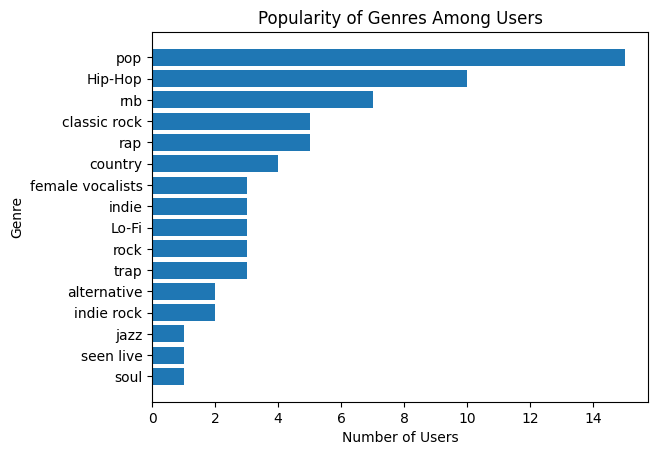

In [ ]:
# Split the rows into two lists: one for the genres and one for the user counts.
genres = [row[0] for row in rows1]
user_counts = [row[1] for row in rows1]

# Create a bar plot.
plt.barh(genres, user_counts)
plt.xlabel('Number of Users')
plt.ylabel('Genre')
plt.title('Popularity of Genres Among Users')
plt.gca().invert_yaxis()
plt.show()

---
Αναπαράσταση **επικάλυψης μουσικών προτιμήσεων** των χρηστών ανά ζευγάρια, χρησιμοποιώντας ένα **heatmap.**

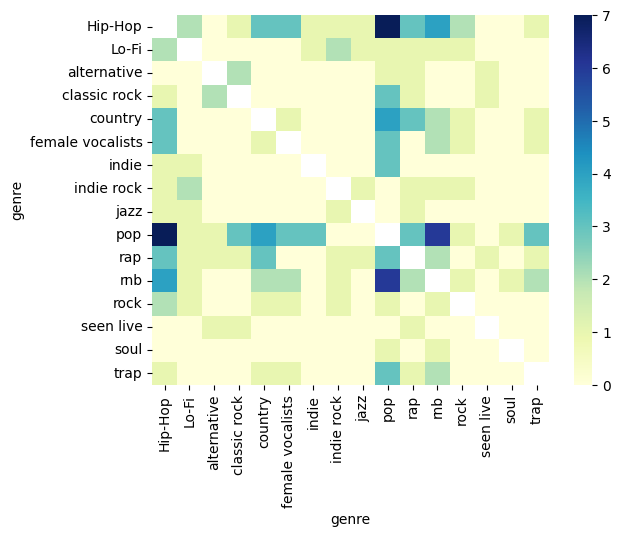

In [ ]:
# Convert the co_occurrence_matrix to a floating-point type, set the diagonal to NaN and then create a heatmap.
co_occurrence_matrix = co_occurrence_matrix.astype(float)
np.fill_diagonal(co_occurrence_matrix.values, np.nan)
sns.heatmap(co_occurrence_matrix, cmap='YlGnBu')
plt.show()

---
Επιπλέον ένας πίνακας με τα παραπάνω δεδομένα του **heatmap.**

In [ ]:
# Set the diagonal values of co_occurrence_matrix to 0 and reset the index of the co-occurrence matrix to convert the index into columns.
np.fill_diagonal(co_occurrence_matrix.values, 0)
co_occurrence_matrix_reset = co_occurrence_matrix.reset_index()

# Melt the DataFrame to create a long format of DataFrame, which consists of pairs of genres and create a new column 'genre_set' which is a set of the two genres.
co_occurrence_pairs = co_occurrence_matrix_reset.melt(id_vars='genre', var_name='genre_2', value_name='overlap')
co_occurrence_pairs['genre_set'] = co_occurrence_pairs.apply(lambda x: frozenset([x['genre'], x['genre_2']]), axis=1)

# Drop duplicates based on 'genre_set' and sort the pairs by overlap in descending order.
co_occurrence_pairs = co_occurrence_pairs.drop_duplicates(subset='genre_set')
co_occurrence_pairs = co_occurrence_pairs.sort_values(by='overlap', ascending=False)

print(co_occurrence_pairs.head())

    genre  genre_2  overlap       genre_set
9     pop  Hip-Hop      7.0  (pop, Hip-Hop)
155   rnb      pop      6.0      (pop, rnb)
73    pop  country      4.0  (pop, country)
11    rnb  Hip-Hop      4.0  (rnb, Hip-Hop)
159  trap      pop      3.0     (pop, trap)


---
Παρακάτω έχουμε και δύο visualizations με **bars και scatterplot** ώστε να γίνει πιο αισθητή η αναλογία playcounts / listeners για κάθε genre μουσικής.

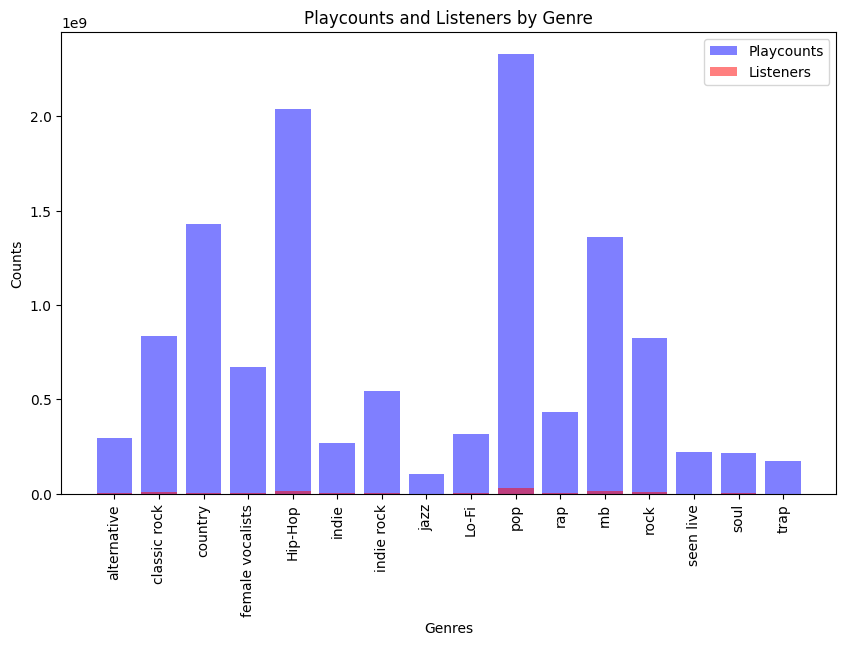

In [ ]:
genres = ['alternative', 'classic rock', 'country', 'female vocalists', 'Hip-Hop', 'indie', 'indie rock', 'jazz', 'Lo-Fi', 'pop', 'rap', 'rnb', 'rock', 'seen live', 'soul', 'trap']
playcounts = [297190682, 837676653, 1427109689, 672057493, 2039376949, 268148179, 546288555, 107765637, 317219163, 2330477658, 432235000, 1358969435, 826654998, 219802950, 214618396, 175784328]
listeners = [4985281, 8181934, 4039073, 3468981, 17385760, 3350684, 5092829, 1543259, 3471690, 32269633, 7050525, 13822596, 10696833, 1430153, 1939339, 1449437]

plt.figure(figsize=(10,6))
plt.bar(genres, playcounts, color='b', alpha=0.5, label='Playcounts')
plt.bar(genres, listeners, color='r', alpha=0.5, label='Listeners')
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.title('Playcounts and Listeners by Genre')
plt.xticks(rotation=90)
plt.legend()
plt.show()

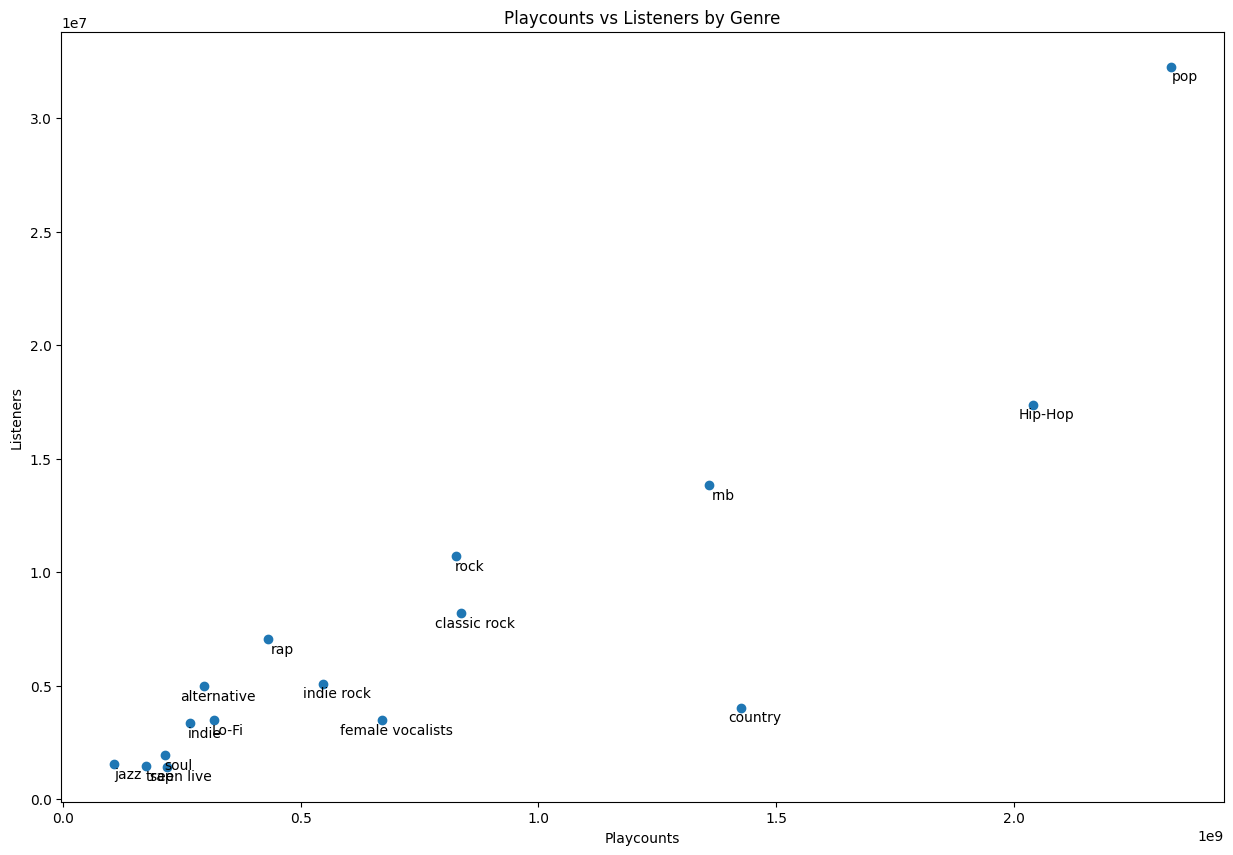

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(playcounts, listeners)
for i, txt in enumerate(genres):
    plt.annotate(txt, (playcounts[i], listeners[i]), textcoords="offset points", xytext=(10,-10), ha='center')
plt.xlabel('Playcounts')
plt.ylabel('Listeners')
plt.title('Playcounts vs Listeners by Genre')
plt.show()

**(στ.) Έστω το synthetic time series dataset στο επόμενο κελί που έχει την χαμηλότερη τιμή που πωλείται ένας δίσκος κάθε μέρα, αναπαραστήστε την χρονοσειρά και το decompose της σε trend, seasonality και residuals [διάλεξη και lab time series].**

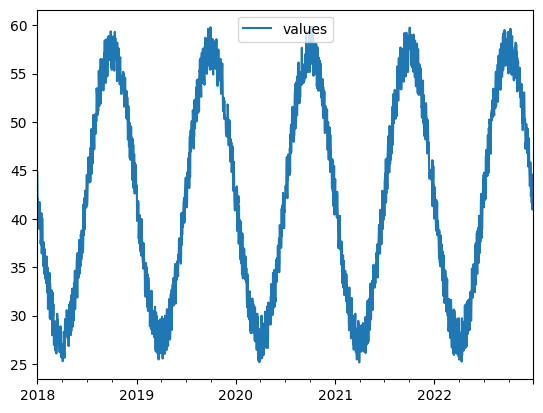

In [ ]:
date_rng = pd.date_range(start='1/1/2018', end='12/31/2022', freq='D')
val=40+15*np.tile(np.sin(np.linspace(-np.pi, np.pi, 365)),5)
val=np.append(val,val[1824])+5*np.random.rand(1826)
series = pd.DataFrame({
    'values': val
}, index=pd.DatetimeIndex(date_rng))
series.plot()
series.to_csv('gdrive/My Drive/File_series.csv', index=True, header=True)

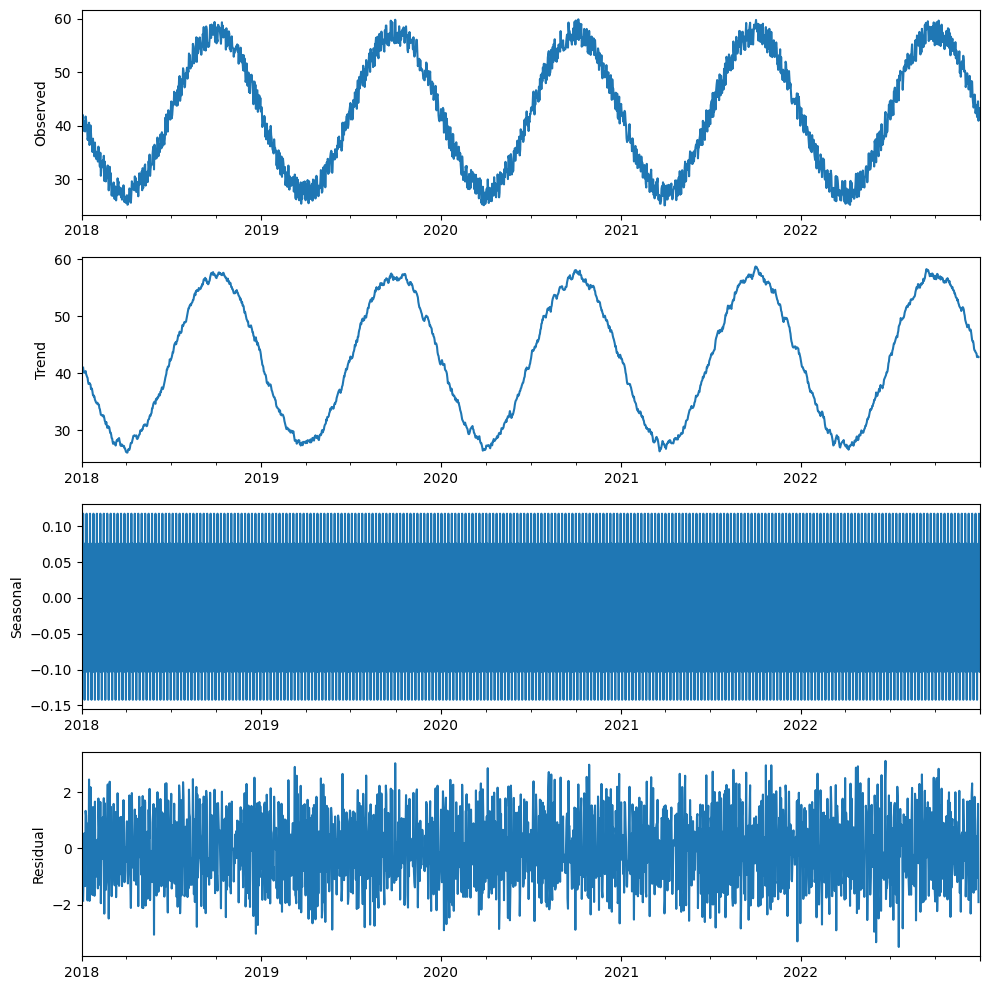

In [ ]:
# Decompose the time series
result = seasonal_decompose(series['values'], model='additive')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,10))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

**(ζ.) Χωρίστε τα data της χρονοσειράς σε 76% training και 34% testing, εκπαιδεύστε ένα ARIMA μοντέλο στο training split το οποίο να προβλέπει την χαμηλότερη τιμή που θα πωλείται ένας δίσκος την επόμενη ημέρα  και αξιολογήστε την απόδοση του στο testing split [διάλεξη και lab time series].**

In [ ]:
X = series.values
size = int(len(X) * 0.76)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

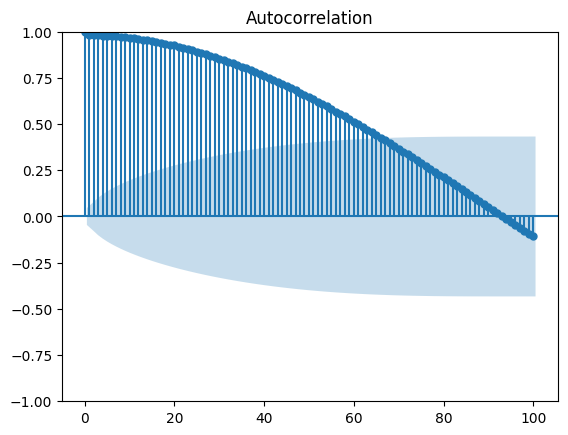

In [ ]:
plot_acf(series, lags=100)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


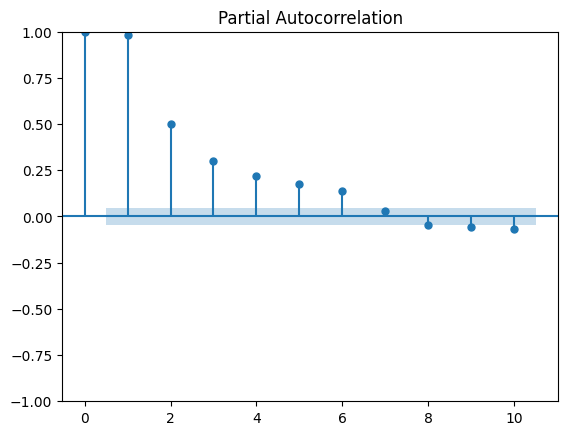

In [ ]:
plot_pacf(series, lags=10)
plt.show()

In [ ]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=56.706064, expected=56.925007
predicted=56.612853, expected=55.481712
predicted=56.172547, expected=54.631481
predicted=55.889747, expected=58.412856
predicted=56.265967, expected=55.342348
predicted=56.156161, expected=54.433038
predicted=55.703370, expected=53.690694
predicted=54.981409, expected=57.797300
predicted=55.702189, expected=57.870631
predicted=56.578949, expected=54.343688
predicted=55.757662, expected=58.093095
predicted=56.304978, expected=56.372504
predicted=56.467427, expected=53.080795
predicted=55.827097, expected=52.980794
predicted=54.857090, expected=57.521327
predicted=55.300433, expected=54.805878
predicted=55.436950, expected=52.805885
predicted=54.498728, expected=54.341616
predicted=54.199561, expected=53.715150
predicted=54.117502, expected=55.952558
predicted=54.846536, expected=54.327471
predicted=54.503132, expected=52.832647
predicted=53.947008, expected=55.166102
predicted=54.362856, expected=54.200884
predicted=54.322896, expected=55.556131


Test RMSE: 1.707


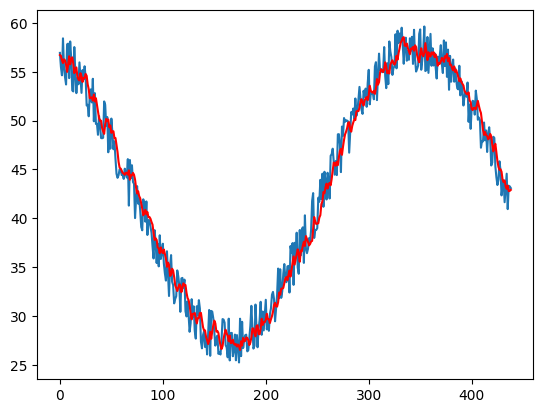

In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset.
    train_size = int(len(X) * 0.76)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions.
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Calculate out of sample error.
    error = mean_squared_error(test, predictions)
    print(error)

arima_order = (5, 1, 0)
error = evaluate_arima_model(X, arima_order)

2.7845327136507927


In [ ]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float64')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3, 4, 5]
evaluate_models(series.values, p_values, d_values, q_values)

111.04778217086525
39.045810562879446
20.687402664881002
14.40183301461889
11.184031650537142


Σε κανονικές συνθήκες το evaluation του arima model θα κατέληγε σε έναν βέλτιστο συνδιασμό. Παρόλαυτα είναι εξαιρετικά χρονοβόρα διαδικασία και δυστυχώς το colab έχει περιορισμένες υπολογιστηκές δυνατότητες οπότε και έπρεπε να διακοπεί. Παρόλαυτα, ο συνδιασμός (5, 1, 0) που διεξάχθηκε από τα παραπάνω acf και pacf plots, παρουσίασε ικανοποιητικά αποτελέσματα με σχετικά μικρό mean squared error.

**(η.) Με χρήση κάποιας graph mining μετρικής πάνω στον γράφο του community να προτείνετε σε κάποιον user έναν δίσκο που δεν έχει επιλέξει [διάλεξη graph mining].**

In [ ]:
mydb = mysql.connector.connect(
    host=db_host,
    port=db_port,
    user=db_user,
    password=db_password,
    database=db_database
)

cursor = mydb.cursor()

cursor.execute("SELECT * FROM User_Records")
rows = cursor.fetchall()
columns = [column[0] for column in cursor.description]
df_user_records = pd.DataFrame(rows, columns=columns)

cursor.execute("SELECT r.record_id, r.name AS record_name, b.name AS band_name, b.genre FROM Records r INNER JOIN Bands b ON r.band_id = b.band_id")
rows = cursor.fetchall()
columns = [column[0] for column in cursor.description]
df_record_details = pd.DataFrame(rows, columns=columns)
record_details_dict = df_record_details.set_index('record_id')[['record_name', 'band_name', 'genre']].to_dict('index')

cursor.close()
mydb.close()

In [ ]:
G = nx.barabasi_albert_graph(20,3)
degree_centrality = nx.degree_centrality(G)

for user_id in G.nodes:
    connected_users = list(G.neighbors(user_id))
    target_user_records = df_user_records[df_user_records['user_id'] == user_id]['record_id'].tolist()
    connected_users_records = df_user_records[df_user_records['user_id'].isin(connected_users)]['record_id'].tolist()
    recommended_records = list(set(connected_users_records) - set(target_user_records))
    recommended_records = recommended_records[:1]

    for record_id in recommended_records:
        details = record_details_dict.get(record_id, {'record_name': 'Unknown', 'band_name': 'Unknown', 'genre': 'Unknown'})
        print(f"Recommended record for user {user_id}: Record ID: {record_id}, Record Name: {details['record_name']}, Band Name: {details['band_name']}, Genre: {details['genre']}")

Recommended record for user 0: Record ID: 380, Record Name: Lana Del Rey - Born To Die, Band Name: Lana Del Rey, Genre: female vocalists
Recommended record for user 1: Record ID: 512, Record Name: Eminem - Stan, Band Name: Eminem, Genre: rap
Recommended record for user 2: Record ID: 512, Record Name: Eminem - Stan, Band Name: Eminem, Genre: rap
Recommended record for user 3: Record ID: 608, Record Name: Billie Eilish - My Boy, Band Name: Billie Eilish, Genre: pop
Recommended record for user 4: Record ID: 532, Record Name: Kali Uchis - Isolation, Band Name: Kali Uchis, Genre: rnb
Recommended record for user 5: Record ID: 512, Record Name: Eminem - Stan, Band Name: Eminem, Genre: rap
Recommended record for user 6: Record ID: 532, Record Name: Kali Uchis - Isolation, Band Name: Kali Uchis, Genre: rnb
Recommended record for user 7: Record ID: 512, Record Name: Eminem - Stan, Band Name: Eminem, Genre: rap
Recommended record for user 8: Record ID: 521, Record Name: Eminem - E, Band Name: Emi

---
Χρησιμοποιήθηκε η τεχνική εύρεσης προτεινόμενου δίσκου, με βάση τον **βαθμό κεντρικότητας**. Με λίγα λόγια, αυτό είναι ένα μέτρο του αριθμού συνδέσεων που έχει ένας κόμβος, δηλαδή εδώ, χρήστης. Έτσι, εντοπίζουμε τους **πιο δημοφιλείς δίσκους**, δηλαδή τους δίσκους με τις **περισσότερες συνδέσεις με χρήστες**.

Αυτό φυσικά θα έχει το αποτέλεσμα, ότι ο κάθε δίσκος που αρέσει στους χρήστες που τείνουν να έχουν περισσότερες ακμές με άλλους χρήστες της κοινότητας, **να προτείνεται και συχνότερα.**

Με αυτό εννοούμε πως αν σε έναν χρήστη με πολλές ακμές αρέσει ο δίσκος **"Eminem - Stan"**, τότε αυτός ο δίσκος έχει εξαιρετικά αυξημένη πιθανότητα να προταθεί αρκετά συχνά σε όποιον άλλον χρήστη δεν του αρέσει ήδη.

Ο κώδικας ουσιαστικά διασχίζει το γράφημα, προσδιορίζει τις συνδέσεις κάθε χρήστη και προτείνει έναν δίσκο που προτιμάται από τους συνδεδεμένους χρήστες αλλά όχι από τον χρήστη-στόχο. Χρησιμοποιεί βαθμό κεντρικόττηας για να εξερευνήσει τη δομή του δικτύου και να προτείνει δίσκους με βάση τις συνδέσεις χρηστών.

Καταληκτικά, η δομή του κώδικα είναι έτσι ώστε να εστιάζεται στην **προσομοίωση συστάσεων** από **χρήστη σε χρήστη** με βάση τεχνικές **εξόρυξης γραφημάτων (graph mining)** ενσωματόνοντας στοιχεία όπως **αναπαράσταση γραφημάτων, βαθμό κεντρικότητας, φιλτράρισμα** και στοχευμένες προτάσεις αποδίδοντας ουσιαστικά αποτελέσματα σε κάθε χρήστη-στόχο.
**bold text**

---

**(θ.) Έστω μια σειρά από users (user_money_rates) που διαθέτουν κάποια χρηματικά ποσά και έχουν εκδηλώσει την βαθμονομημένη επιθυμία τους να αγοράσουν μια σειρά από δίσκους. Η επιθυμία εκδηλώνεται με έναν βαθμό απο 1 εως 5 για κάθε δίσκο και κάθε δίσκος έχει ένα χρηματικό κόστος (album_price). Χρησιμοποιήστε έναν γενετικό αλγόριθμο για να επιλέξει τους δίσκους που θα προτείνει στους users να αγοράσουν με σκοπό να μεγιστοποιήσουν τον συνολικό βαθμό επιθυμίας των δίσκων, δεδομένου του διαθέσιμου χρηματικού ποσού που διαθέτει ο κάθε user. Συγκρίνετε τα αποτελέσματα με μια τυχαία επιλογή δίσκων. [διάλεξη genetic algorithms].**

In [ ]:
users_money = 200 + np.ceil(100*np.random.rand(100))
user_money_rates=np.empty_like(np.append(users_money[0],np.random.randint(5, size=100)+1))
for i in users_money:
  user_money_rates=np.vstack([user_money_rates,np.append(i,np.random.randint(5, size=100)+1)])
user_money_rates=np.delete(user_money_rates,(0),axis=0)

album_price=np.random.randint(50, size=100)+1
np.savetxt("gdrive/My Drive/user_money_rates.csv", user_money_rates, delimiter=",")
np.savetxt("gdrive/My Drive/album_price.csv", album_price, delimiter=",")

In [ ]:
user_money_rates = pd.read_csv("gdrive/My Drive/user_money_rates.csv", header=None)
album_price = pd.read_csv("gdrive/My Drive/album_price.csv", header=None)

def calculate_fitness(individual, prices, rates, money):
    cost = np.sum(individual * prices)
    value = np.sum(individual * rates)
    if cost > money:
        return 0
    else:
        return value

def generate_individual(n_discs):
    return np.random.randint(2, size=n_discs)

def tournament_selection(population, fitnesses, tournament_size=3):
    selected_indices = np.random.choice(np.arange(len(population)), size=tournament_size)
    tournament_individuals = population[selected_indices]
    tournament_fitnesses = fitnesses[selected_indices]
    winner_index = selected_indices[np.argmax(tournament_fitnesses)]
    return population[winner_index]

def crossover(parents): # One point crossover.
    crossover_point = np.random.randint(len(parents[0]))
    child1 = np.concatenate((parents[0][:crossover_point], parents[1][crossover_point:]))
    child2 = np.concatenate((parents[1][:crossover_point], parents[0][crossover_point:]))
    return child1, child2

def mutation(individual, prices, money, mutation_rate=0.01):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] = 1 - individual[i]
    # Repair function.
    while np.sum(individual * prices) > money:
        selected_discs = [i for i, x in enumerate(individual) if x == 1]
        individual[np.random.choice(selected_discs)] = 0
    return individual

def genetic_algorithm(n_individuals, n_discs, prices, rates, money, n_generations=150, elitism_size=8):
    population = np.array([generate_individual(n_discs) for _ in range(n_individuals)])
    best_fitnesses = []

    for _ in range(n_generations):
        fitnesses = np.array([calculate_fitness(individual, prices, rates, money) for individual in population])
        best_fitnesses.append(np.max(fitnesses))

        # Elitism: keep the best individuals.
        elite_indices = np.argsort(fitnesses)[-elitism_size:]
        elite_individuals = population[elite_indices]

        new_population = []
        for _ in range((n_individuals - elitism_size) // 2):
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child1, child2 = crossover([parent1, parent2])
            new_population.append(mutation(child1, album_price, user_money))
            new_population.append(mutation(child2, album_price, user_money))

        population = np.concatenate((np.array(new_population), elite_individuals))

    fitnesses = np.array([calculate_fitness(individual, prices, rates, money) for individual in population])
    best_individual = population[np.argmax(fitnesses)]
    return best_individual, best_fitnesses

def get_selected_discs(individual):
    return [i for i, x in enumerate(individual) if x == 1]

---

Το greedy selection αυτό λειτουργεί βρίσκοντας την αναλογία βαθμού επιθυμίας προς τιμή, και έπειτα, διαλέγει δίσκους μέχρι να εξαντληθούν τα χρήματα του κάθε χρήστη.

In [ ]:
def greedy_selection(n_discs, prices, rates, money):
    individual = np.zeros(n_discs, dtype=int)
    disc_indices = np.argsort(-rates/prices)
    for i in disc_indices:
        if prices[i] <= money:
            individual[i] = 1
            money -= prices[i]

    return individual

---

Παρακάτω τρέχει ο γενετικός αλγόριθμος και έπειτα, κάνουμε plot το καλύτερο fitness από generation σε generation χώρις να γίνεται κάποια σύγκριση. Στο επόμενο code block υπάρχει και η σύγκριση με χρήση "greedy selection".

User 1 should buy discs [6, 10, 14, 18, 19, 22, 23, 28, 30, 37, 39, 40, 43, 48, 53, 56, 57, 60, 61, 71, 73, 74, 84, 92, 93, 97, 98]


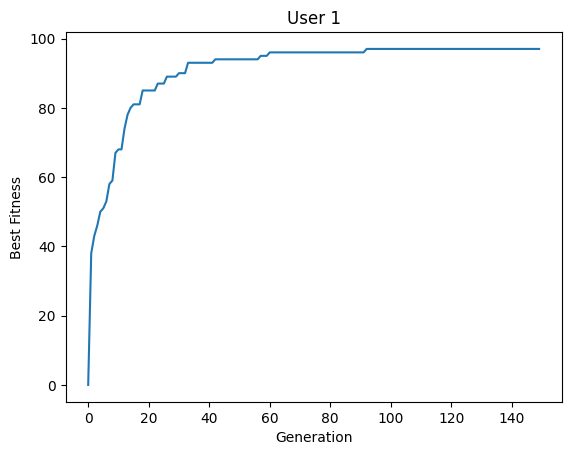

User 2 should buy discs [4, 6, 7, 10, 14, 18, 19, 22, 23, 28, 30, 33, 39, 43, 46, 53, 56, 60, 61, 70, 72, 73, 74, 79, 93, 97, 98]


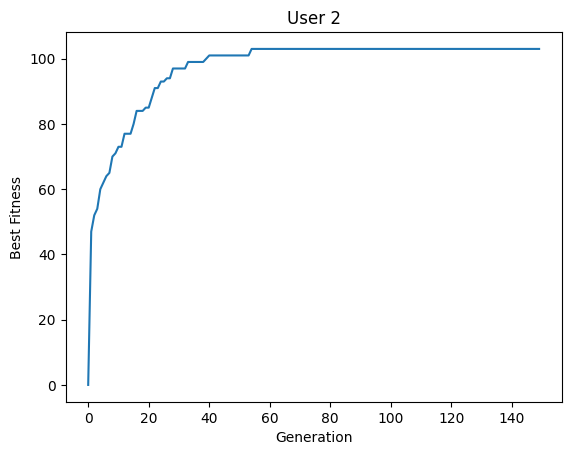

User 3 should buy discs [6, 7, 10, 14, 18, 19, 22, 30, 33, 37, 39, 41, 43, 53, 56, 57, 60, 61, 70, 73, 74, 79, 92, 93, 94, 97, 98]


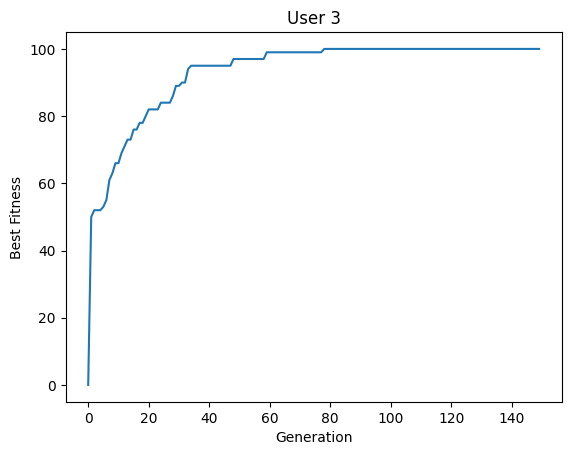

User 4 should buy discs [4, 6, 7, 10, 11, 14, 18, 19, 22, 33, 37, 39, 40, 41, 43, 48, 53, 54, 56, 57, 60, 61, 70, 71, 72, 73, 74, 93, 94, 97, 98]


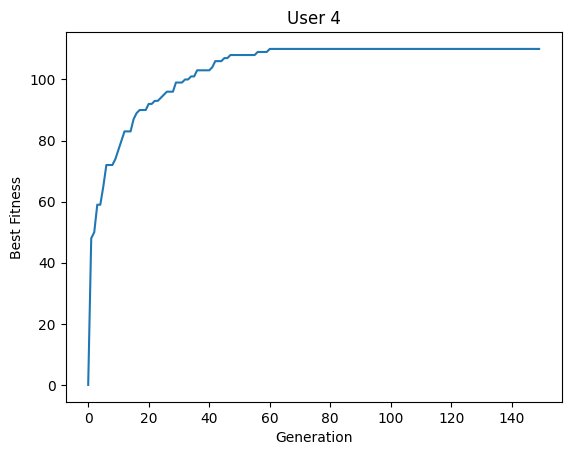

User 5 should buy discs [3, 7, 10, 12, 14, 18, 19, 23, 26, 28, 33, 48, 53, 56, 61, 70, 71, 73, 74, 79, 86, 92, 93, 98]


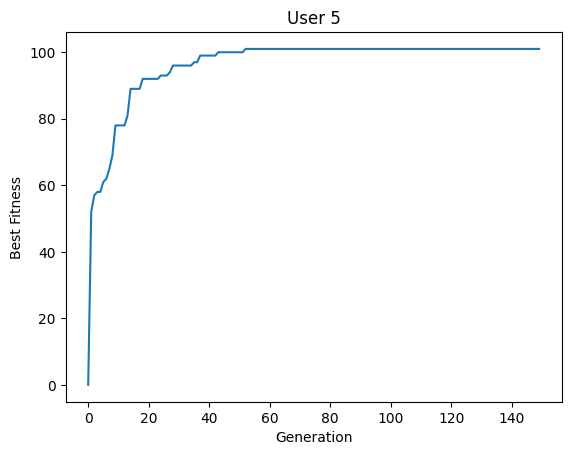

User 6 should buy discs [4, 10, 14, 18, 19, 22, 23, 39, 43, 53, 56, 60, 61, 70, 71, 72, 73, 74, 78, 84, 86, 88, 93, 94, 97, 98]


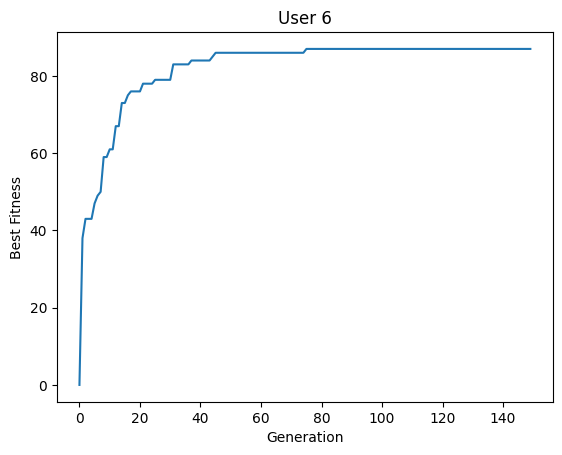

User 7 should buy discs [6, 7, 10, 14, 18, 19, 22, 28, 30, 33, 36, 39, 40, 43, 48, 53, 54, 56, 57, 60, 61, 65, 72, 73, 74, 86, 93, 94, 95, 98]


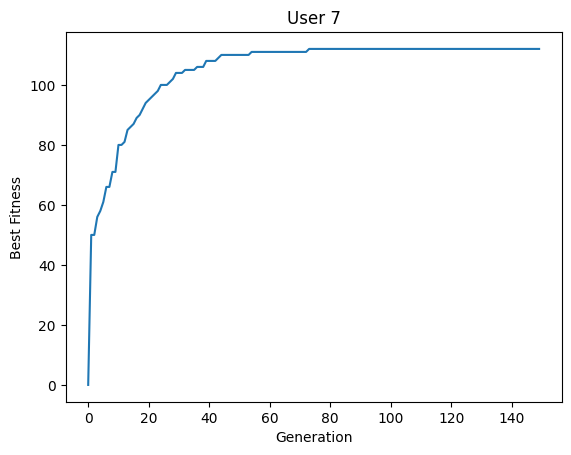

User 8 should buy discs [7, 10, 14, 18, 30, 39, 40, 43, 48, 53, 56, 57, 60, 61, 65, 70, 72, 73, 78, 84, 92, 93, 94, 97, 98]


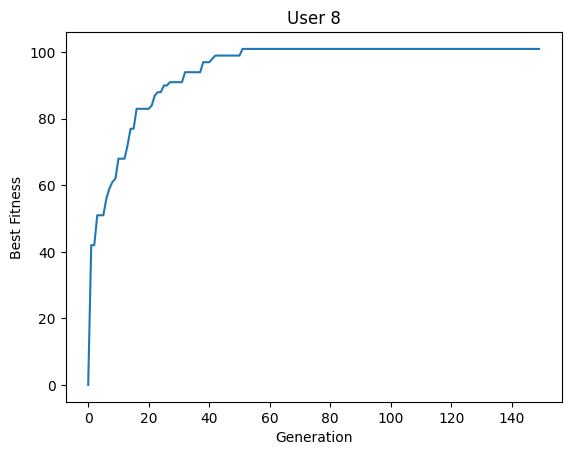

User 9 should buy discs [4, 6, 10, 14, 18, 19, 26, 28, 37, 40, 43, 48, 54, 56, 57, 61, 70, 73, 74, 78, 80, 84, 86, 93, 94, 95, 97, 98]


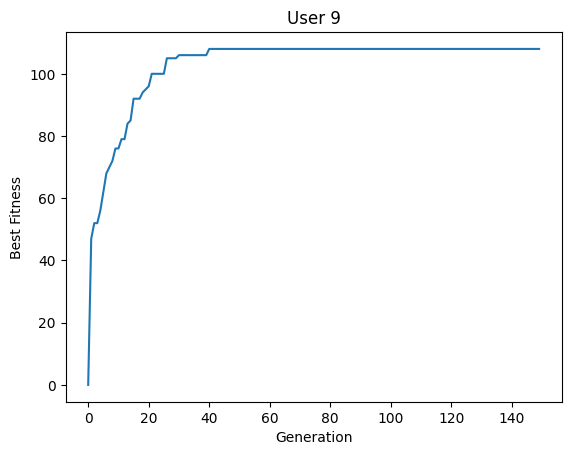

User 10 should buy discs [6, 7, 10, 14, 18, 19, 30, 33, 39, 40, 48, 53, 54, 56, 57, 61, 70, 71, 72, 73, 74, 84, 86, 93, 94, 95, 96, 97]


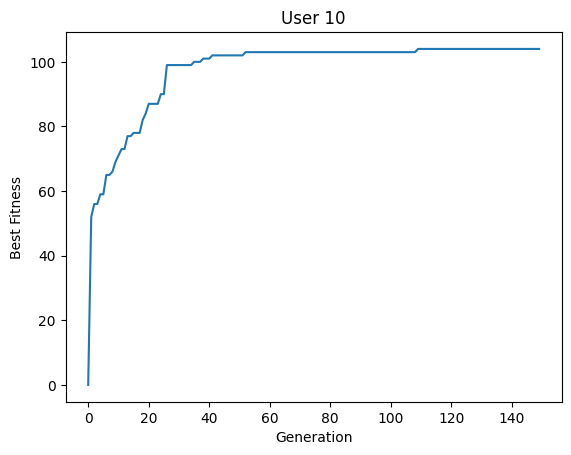

User 11 should buy discs [4, 10, 14, 18, 19, 23, 30, 36, 39, 43, 48, 53, 56, 57, 59, 61, 65, 70, 73, 88, 93, 98]


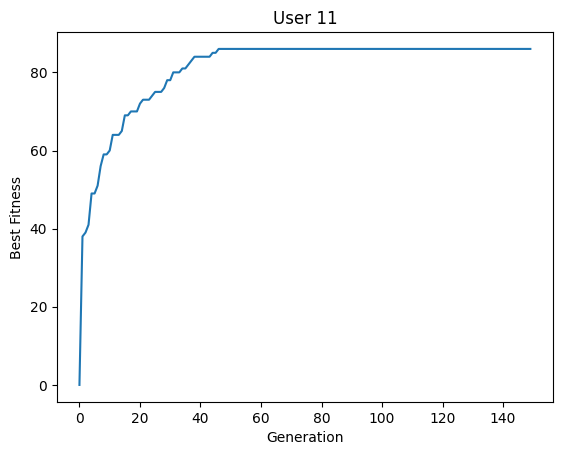

User 12 should buy discs [6, 10, 14, 17, 18, 19, 22, 23, 28, 33, 37, 39, 40, 43, 53, 54, 56, 60, 61, 70, 71, 72, 73, 74, 78, 79, 86, 92, 93, 97, 98]


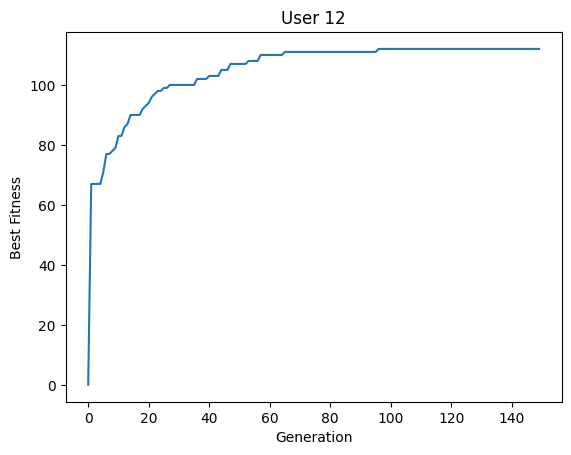

User 13 should buy discs [6, 7, 14, 18, 19, 23, 28, 30, 37, 39, 40, 48, 53, 54, 56, 57, 60, 61, 65, 73, 74, 84, 86, 89, 93, 94, 97, 98]


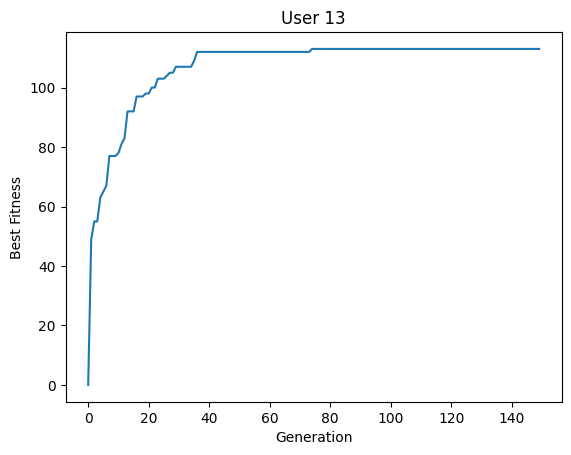

User 14 should buy discs [6, 7, 10, 14, 18, 19, 23, 36, 40, 48, 53, 56, 60, 61, 70, 71, 72, 73, 74, 78, 86, 92, 93, 94, 97, 98]


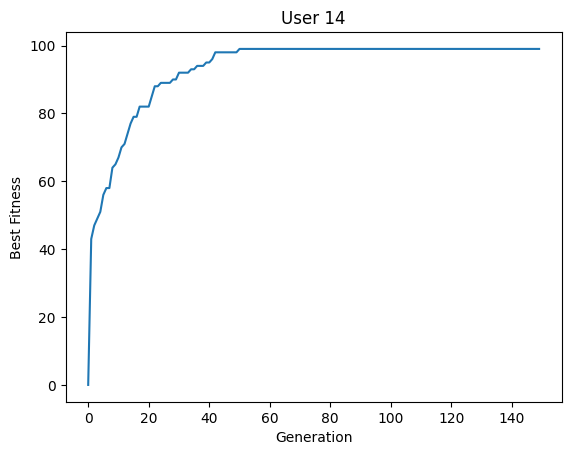

User 15 should buy discs [7, 14, 18, 19, 28, 33, 39, 40, 43, 48, 53, 56, 59, 60, 61, 70, 72, 73, 74, 84, 93, 95, 98]


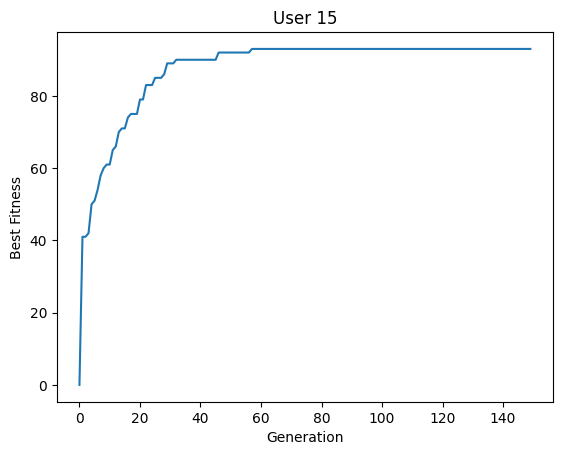

User 16 should buy discs [4, 6, 7, 14, 18, 22, 23, 26, 39, 40, 48, 53, 56, 57, 59, 60, 61, 70, 71, 72, 73, 74, 78, 79, 86, 94, 97, 98]


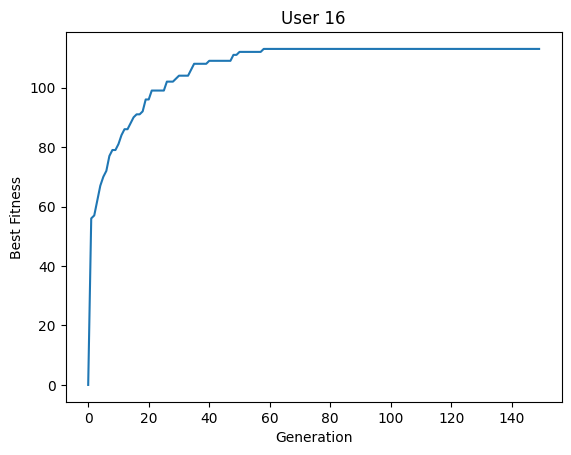

User 17 should buy discs [3, 10, 14, 18, 30, 33, 39, 43, 48, 53, 56, 60, 61, 70, 72, 73, 74, 79, 86, 89, 92, 93, 94, 96, 98]


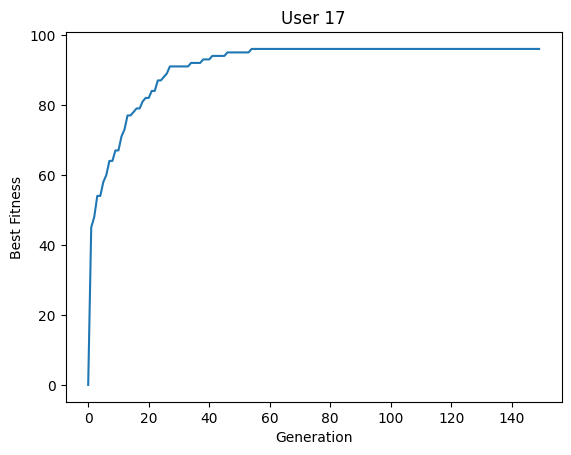

User 18 should buy discs [6, 10, 14, 18, 22, 23, 33, 39, 48, 53, 54, 56, 57, 61, 65, 70, 71, 73, 74, 86, 92, 93, 97, 98]


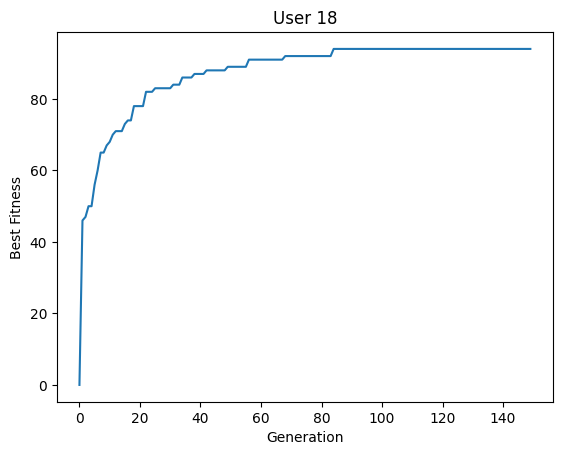

User 19 should buy discs [6, 10, 14, 17, 18, 19, 22, 23, 30, 33, 40, 43, 53, 54, 56, 57, 59, 60, 61, 64, 70, 72, 73, 74, 84, 86, 93, 94, 97, 98]


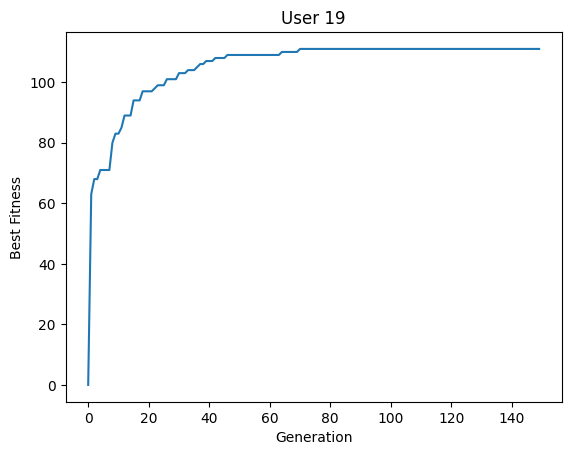

User 20 should buy discs [4, 6, 10, 14, 18, 19, 25, 28, 30, 39, 41, 43, 53, 54, 56, 60, 61, 71, 72, 73, 74, 84, 89, 93, 94, 97, 98]


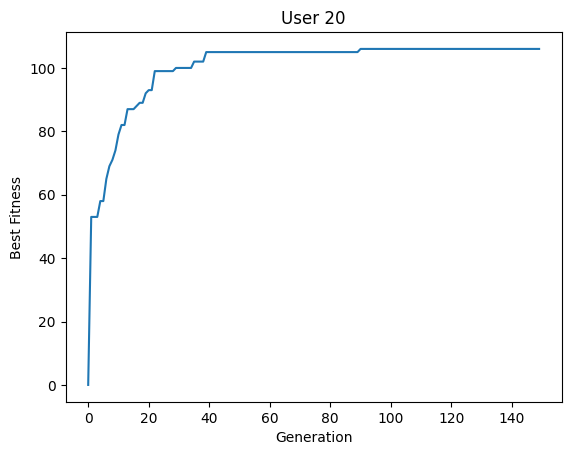

User 21 should buy discs [6, 10, 14, 18, 19, 28, 30, 33, 37, 40, 43, 48, 54, 56, 59, 60, 61, 71, 72, 73, 74, 86, 89, 92, 93, 94]


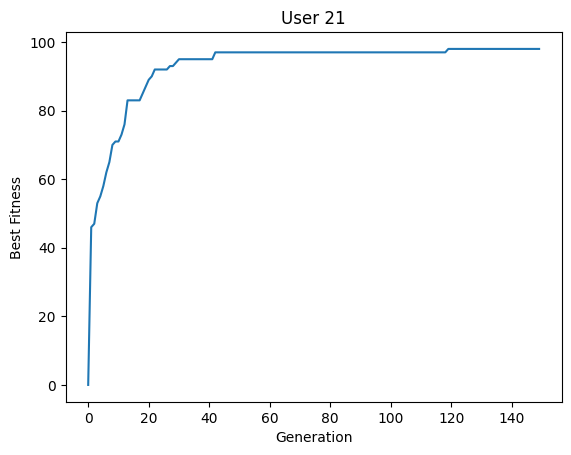

User 22 should buy discs [6, 7, 10, 11, 14, 18, 19, 23, 26, 33, 37, 48, 53, 54, 56, 57, 59, 61, 71, 72, 73, 74, 78, 93, 95, 97, 98]


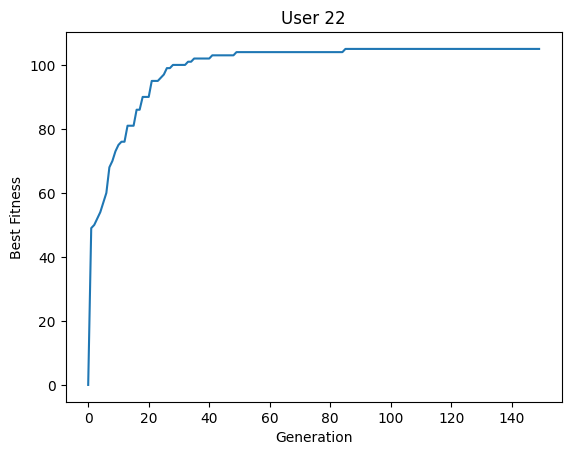

User 23 should buy discs [6, 7, 10, 14, 18, 22, 28, 37, 40, 43, 48, 53, 54, 56, 57, 60, 61, 70, 71, 73, 74, 78, 92, 93, 94, 97, 98]


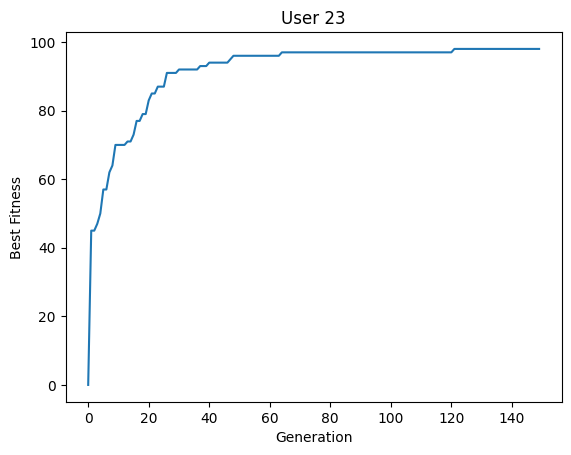

User 24 should buy discs [4, 6, 10, 14, 18, 19, 22, 28, 30, 39, 40, 46, 48, 53, 54, 56, 60, 61, 70, 72, 73, 79, 84, 93, 97, 98]


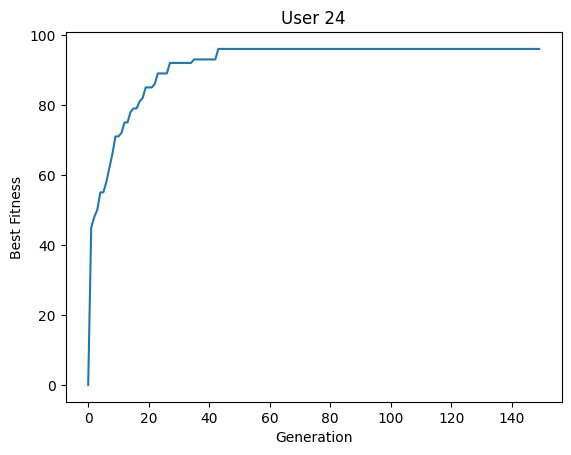

User 25 should buy discs [7, 10, 14, 18, 22, 23, 25, 33, 37, 39, 40, 43, 48, 53, 56, 57, 60, 61, 65, 68, 71, 73, 74, 78, 84, 92, 93, 98]


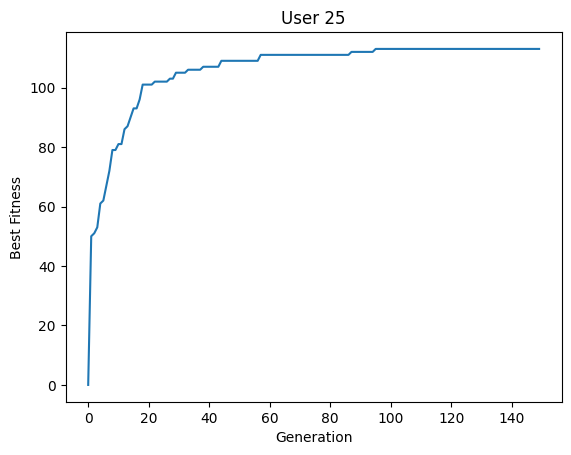

User 26 should buy discs [4, 10, 14, 17, 18, 23, 33, 37, 40, 43, 48, 53, 54, 56, 57, 60, 61, 70, 71, 73, 74, 86, 93, 97]


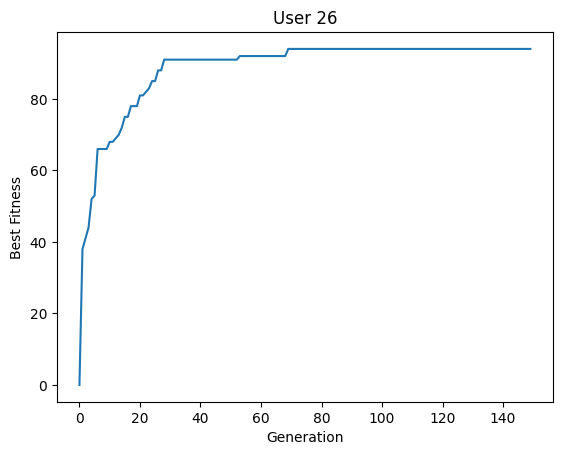

User 27 should buy discs [4, 6, 7, 14, 18, 19, 23, 26, 28, 37, 39, 40, 41, 43, 60, 61, 70, 71, 72, 73, 74, 78, 79, 95, 97, 98]


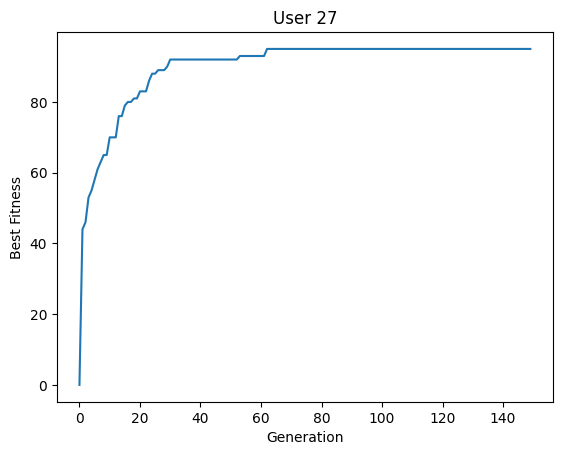

User 28 should buy discs [4, 6, 7, 10, 12, 14, 18, 22, 25, 30, 43, 56, 59, 60, 61, 65, 70, 71, 72, 73, 74, 78, 93, 94, 97, 98]


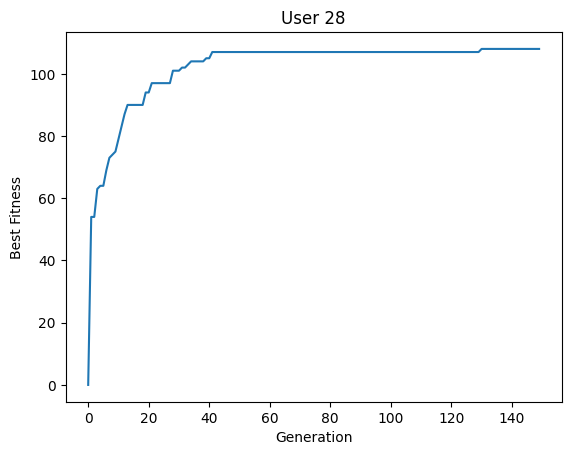

User 29 should buy discs [4, 6, 7, 14, 18, 22, 23, 28, 33, 37, 39, 40, 43, 53, 56, 57, 60, 61, 65, 71, 73, 74, 79, 86, 93, 94, 97, 98]


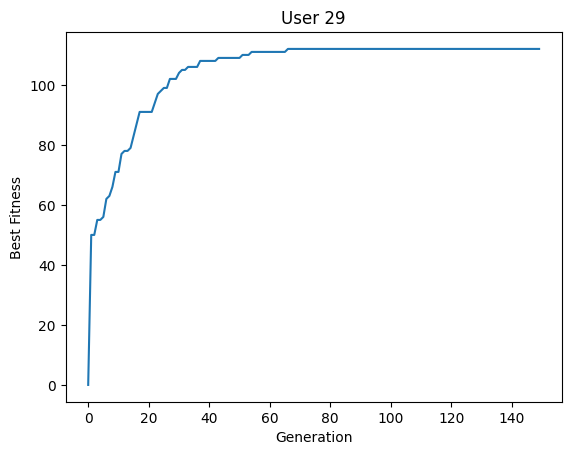

User 30 should buy discs [6, 7, 10, 14, 18, 19, 22, 23, 30, 37, 39, 41, 53, 56, 57, 60, 61, 65, 70, 71, 72, 73, 74, 79, 92, 93, 94, 97]


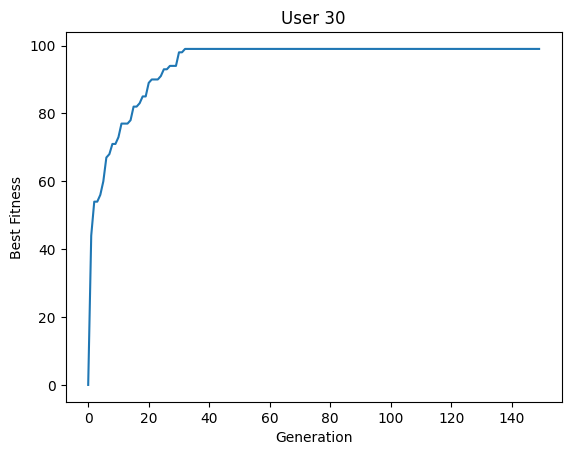

User 31 should buy discs [4, 6, 10, 14, 18, 19, 23, 25, 30, 37, 43, 48, 53, 56, 57, 59, 61, 70, 73, 74, 78, 84, 93, 94, 97, 98]


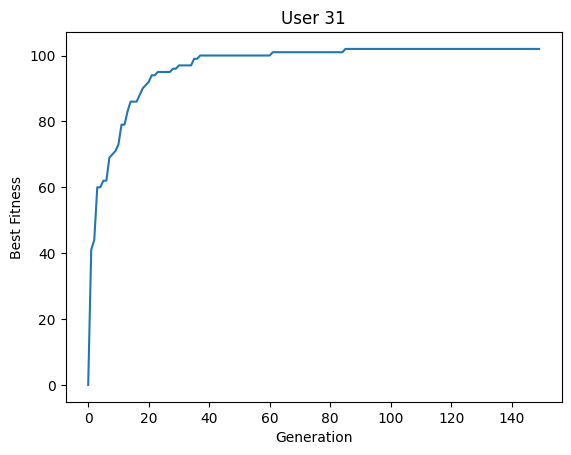

User 32 should buy discs [5, 10, 14, 18, 22, 23, 30, 33, 39, 53, 54, 56, 57, 59, 61, 71, 72, 73, 74, 89, 93, 97, 98]


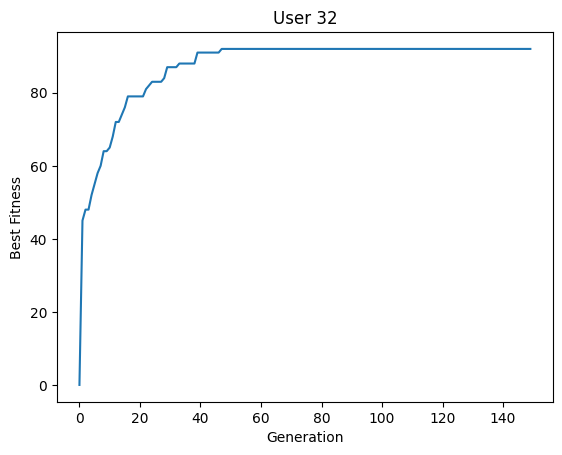

User 33 should buy discs [6, 10, 14, 18, 19, 25, 28, 40, 43, 48, 49, 53, 56, 57, 61, 71, 72, 73, 74, 79, 88, 92, 93, 97]


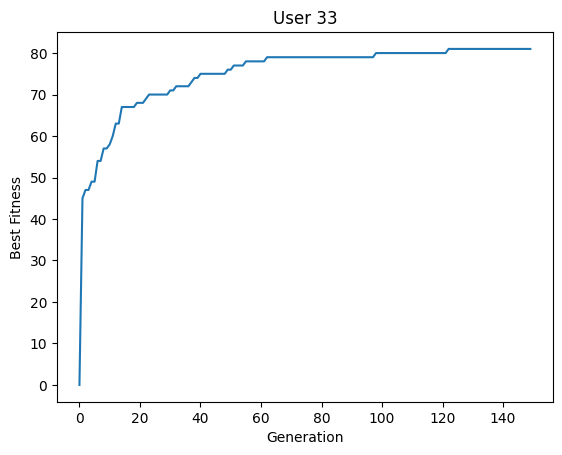

User 34 should buy discs [4, 7, 10, 14, 18, 19, 22, 23, 28, 37, 39, 43, 53, 54, 56, 61, 65, 70, 71, 74, 86, 93, 94, 98]


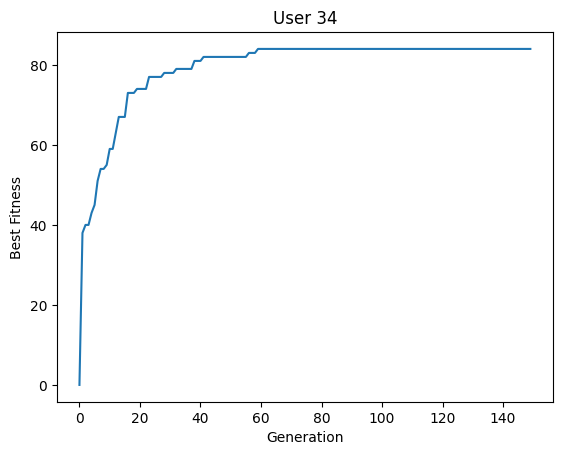

User 35 should buy discs [4, 6, 7, 10, 14, 18, 36, 39, 40, 45, 48, 53, 56, 60, 61, 70, 72, 73, 78, 84, 93, 96, 97, 98]


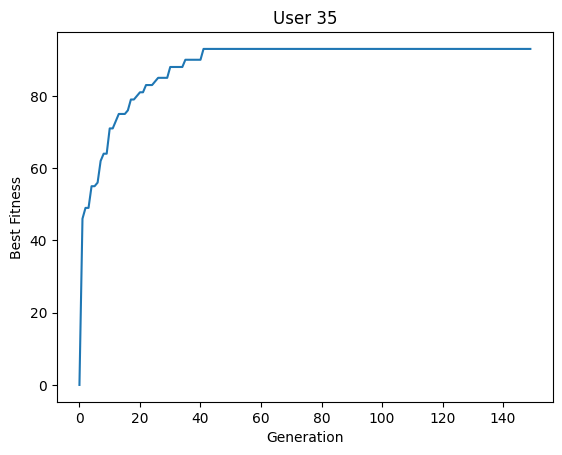

User 36 should buy discs [4, 6, 7, 14, 17, 18, 19, 26, 30, 37, 39, 43, 45, 54, 56, 59, 60, 61, 65, 70, 71, 73, 74, 79, 88, 93, 98]


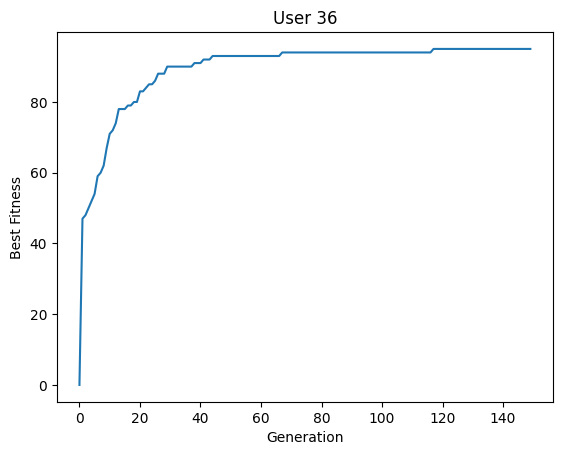

User 37 should buy discs [6, 10, 14, 17, 18, 23, 25, 28, 37, 39, 40, 41, 43, 53, 54, 56, 61, 65, 70, 71, 72, 74, 86, 92, 93, 97, 98]


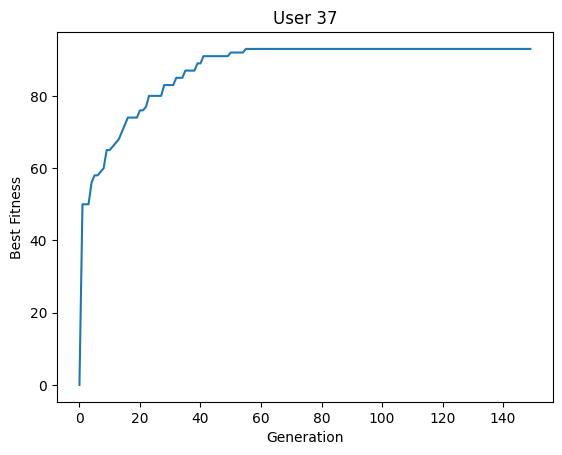

User 38 should buy discs [4, 6, 10, 14, 18, 19, 22, 39, 40, 43, 48, 53, 56, 61, 65, 70, 71, 72, 73, 74, 78, 79, 86, 89, 93, 97, 98]


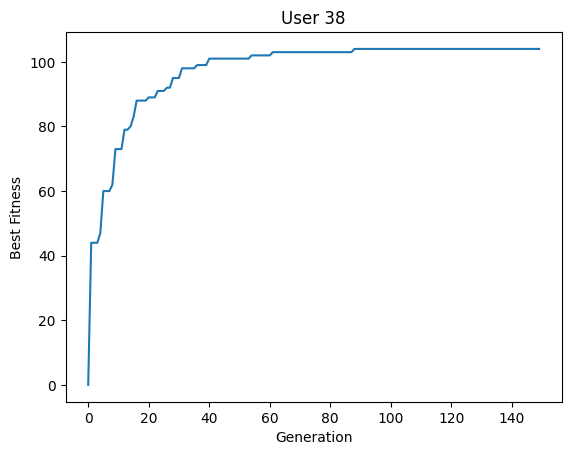

User 39 should buy discs [4, 6, 10, 14, 18, 19, 23, 33, 39, 40, 43, 53, 54, 56, 57, 60, 61, 70, 71, 73, 74, 86, 89, 93, 94, 97, 98]


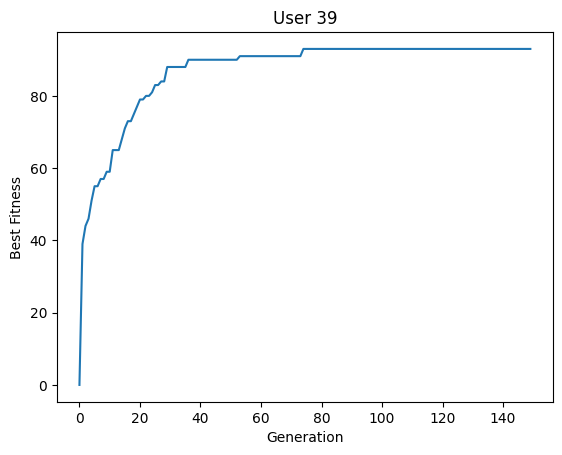

User 40 should buy discs [6, 14, 18, 19, 23, 26, 28, 30, 37, 39, 43, 46, 53, 54, 56, 57, 61, 71, 72, 73, 74, 84, 86, 93, 97, 98]


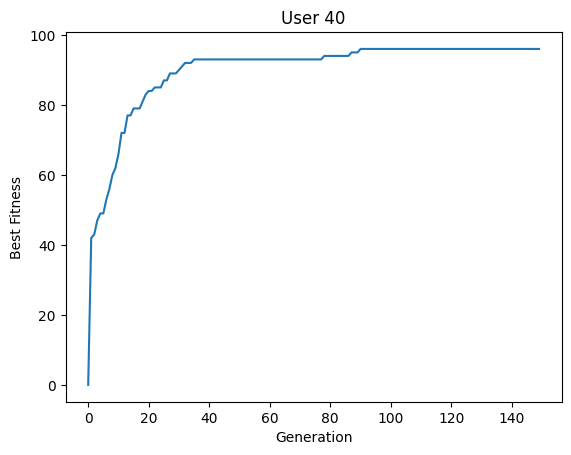

User 41 should buy discs [4, 6, 10, 12, 14, 17, 18, 19, 23, 33, 37, 43, 53, 56, 57, 61, 68, 70, 71, 72, 74, 79, 84, 86, 93, 94, 97, 98]


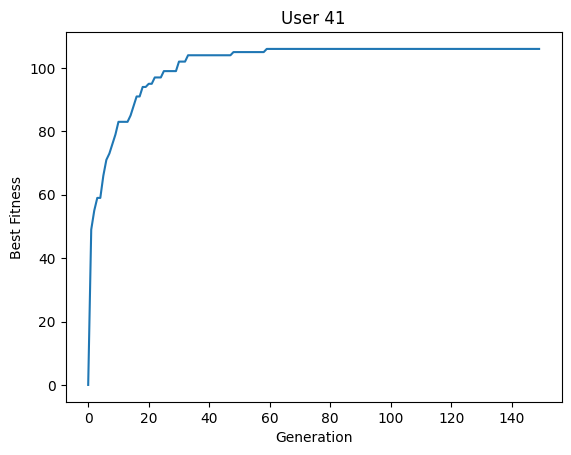

User 42 should buy discs [6, 10, 14, 18, 19, 23, 30, 37, 39, 40, 43, 46, 54, 56, 61, 64, 70, 73, 74, 78, 80, 84, 86, 93, 97, 98]


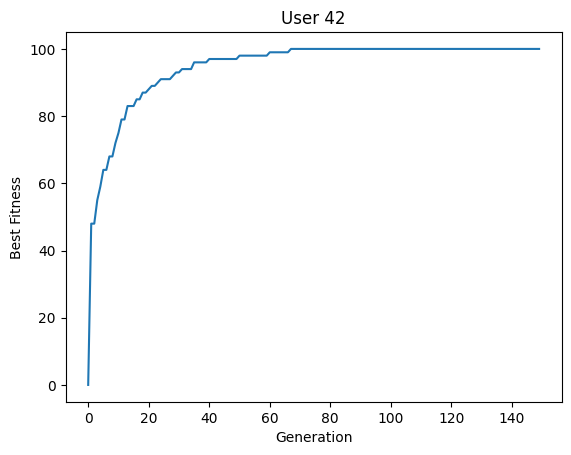

User 43 should buy discs [4, 6, 10, 14, 18, 19, 23, 30, 39, 40, 48, 53, 54, 56, 57, 61, 65, 70, 71, 72, 73, 74, 78, 79, 80, 86, 92, 93, 97, 98]


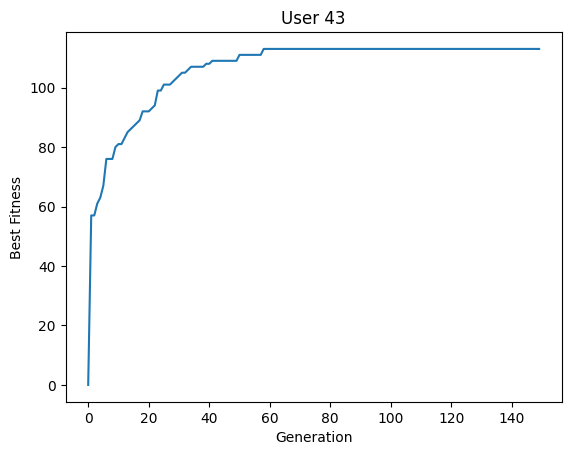

User 44 should buy discs [4, 6, 7, 10, 14, 18, 19, 23, 30, 39, 40, 43, 48, 53, 54, 56, 57, 60, 61, 71, 74, 79, 84, 86, 93, 94, 98]


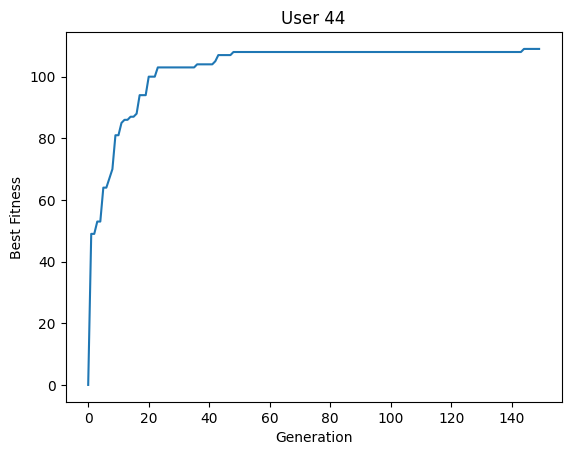

User 45 should buy discs [4, 6, 10, 14, 18, 19, 33, 39, 43, 53, 56, 57, 59, 61, 71, 72, 73, 74, 78, 86, 93, 95, 96, 97, 98]


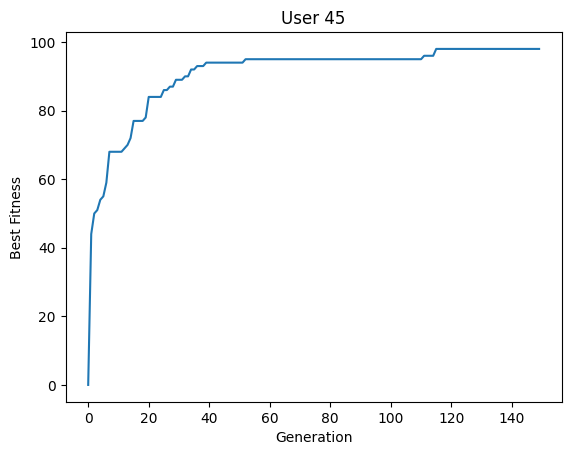

User 46 should buy discs [4, 6, 10, 14, 19, 22, 26, 30, 37, 39, 48, 53, 56, 57, 59, 61, 70, 72, 73, 74, 78, 84, 92, 93, 94, 97, 98]


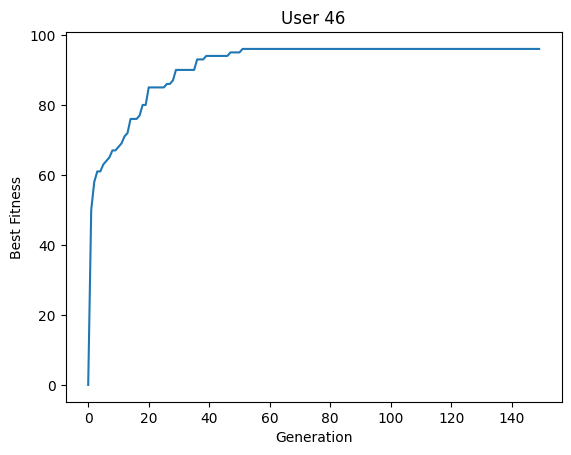

User 47 should buy discs [14, 18, 19, 30, 36, 39, 40, 43, 53, 56, 60, 61, 65, 71, 72, 73, 74, 78, 86, 89, 93, 94, 97, 98]


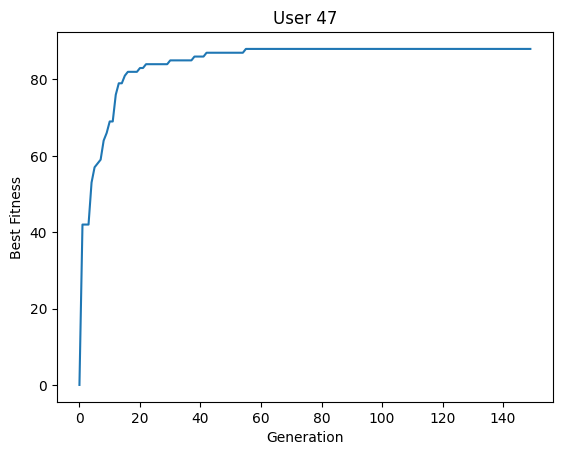

User 48 should buy discs [6, 12, 14, 18, 22, 23, 30, 33, 37, 39, 41, 43, 48, 53, 56, 60, 61, 68, 70, 71, 73, 74, 80, 84, 93, 97, 98]


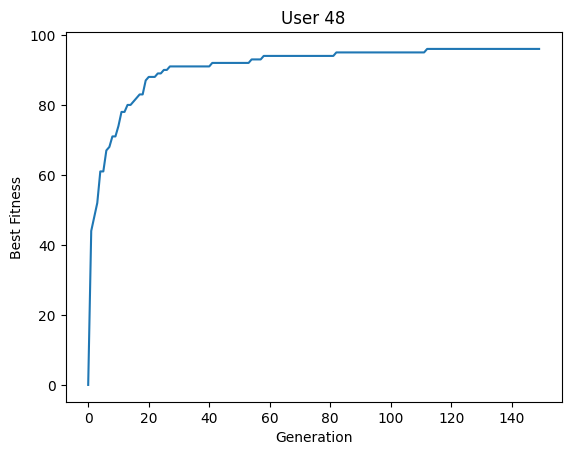

User 49 should buy discs [6, 7, 14, 18, 19, 22, 23, 30, 33, 39, 40, 41, 43, 48, 53, 56, 57, 60, 61, 65, 70, 73, 74, 78, 84, 93]


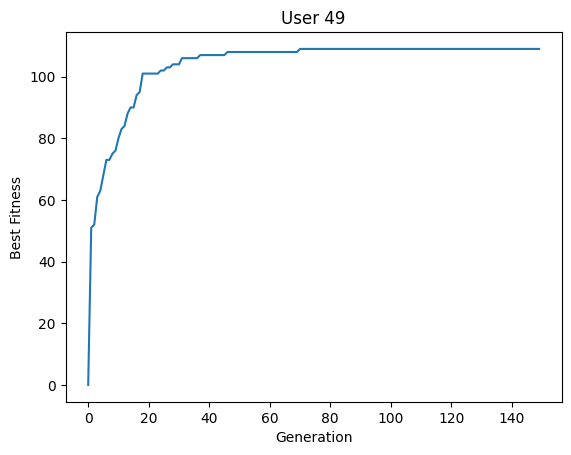

User 50 should buy discs [4, 6, 7, 10, 14, 18, 19, 22, 23, 33, 39, 48, 53, 56, 60, 61, 65, 71, 74, 78, 86, 92, 93, 97, 98]


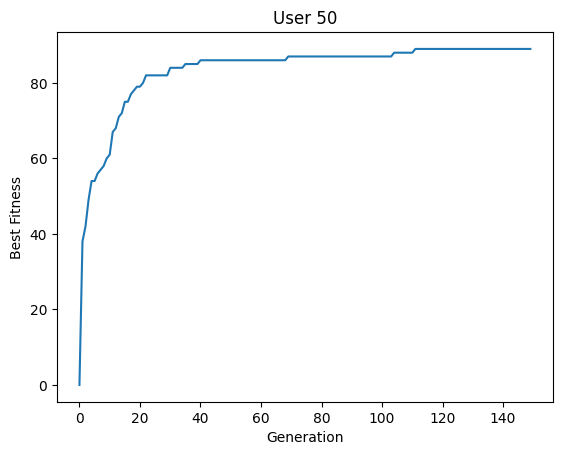

User 51 should buy discs [6, 10, 11, 14, 18, 19, 30, 33, 39, 40, 43, 48, 53, 56, 60, 61, 65, 70, 71, 72, 73, 74, 79, 86, 88, 92, 93, 94, 97, 98]


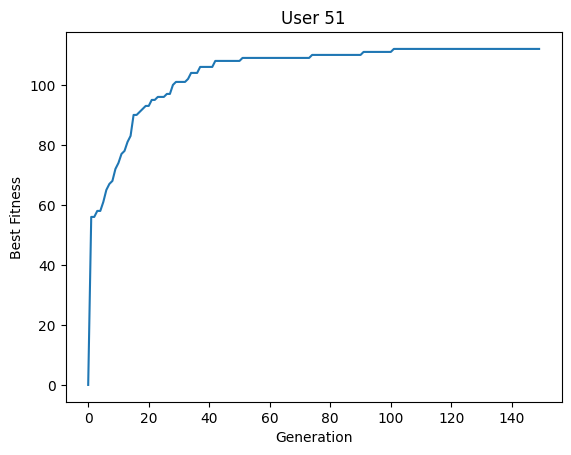

User 52 should buy discs [4, 6, 7, 10, 14, 18, 19, 22, 23, 26, 37, 39, 43, 53, 56, 57, 61, 65, 70, 73, 74, 79, 86, 93, 94, 95, 97, 98]


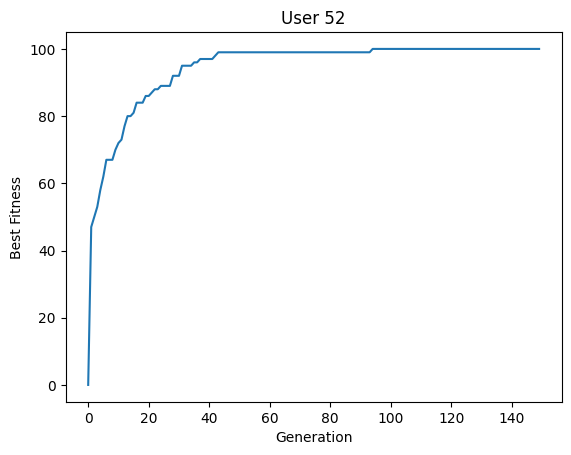

User 53 should buy discs [6, 7, 10, 14, 17, 18, 19, 22, 26, 30, 33, 39, 40, 48, 53, 56, 57, 60, 61, 65, 70, 72, 73, 74, 79, 92, 93, 97, 98]


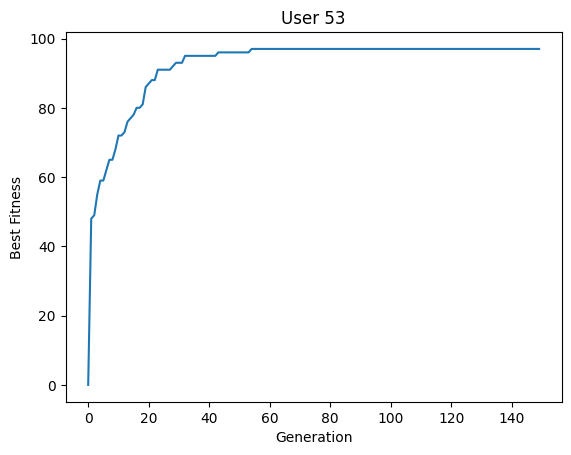

User 54 should buy discs [6, 14, 18, 19, 30, 33, 43, 48, 53, 54, 56, 59, 60, 61, 65, 70, 71, 72, 73, 78, 93, 94, 97, 98]


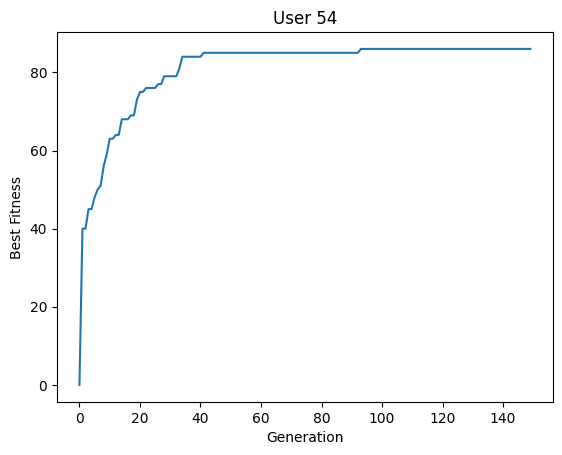

User 55 should buy discs [4, 6, 14, 18, 30, 33, 36, 39, 40, 41, 53, 54, 56, 60, 61, 70, 71, 72, 73, 74, 78, 79, 88, 93, 97, 98]


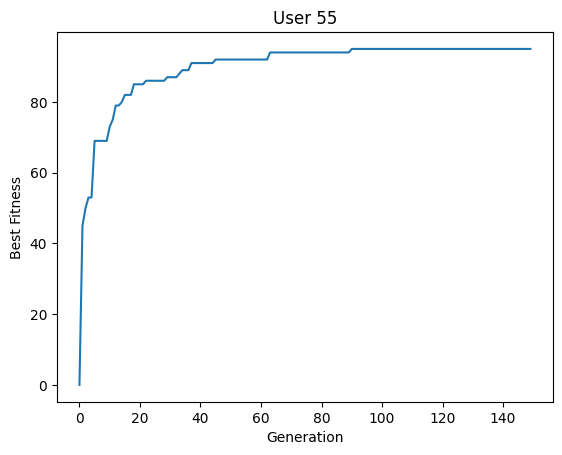

User 56 should buy discs [4, 6, 14, 18, 19, 23, 25, 30, 33, 39, 40, 43, 48, 53, 54, 56, 60, 61, 70, 73, 74, 93, 94, 98]


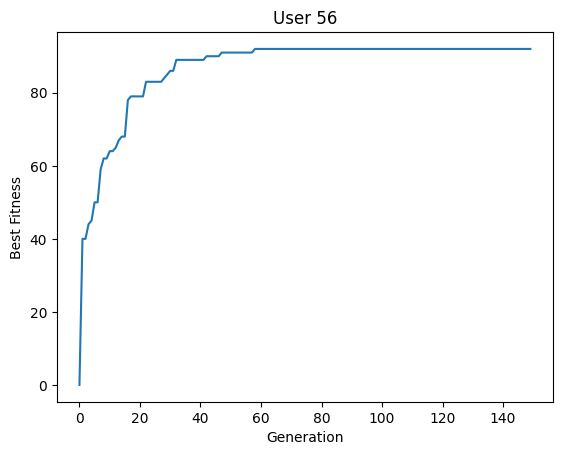

User 57 should buy discs [6, 7, 10, 14, 18, 19, 22, 25, 28, 36, 40, 43, 53, 56, 57, 61, 70, 71, 72, 73, 74, 78, 84, 89, 92, 93, 98]


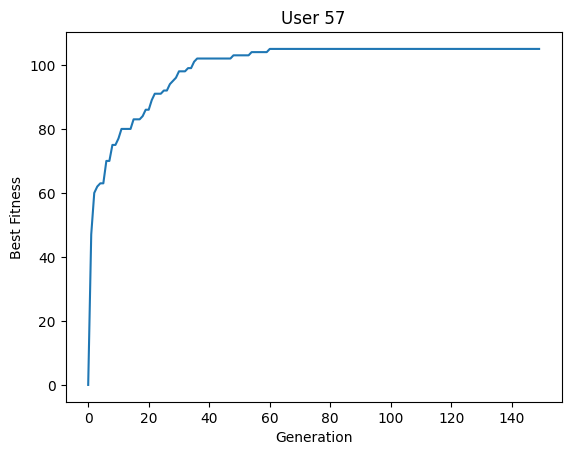

User 58 should buy discs [6, 7, 10, 14, 18, 19, 22, 28, 33, 39, 40, 53, 54, 56, 57, 59, 60, 61, 72, 73, 74, 80, 84, 92, 93, 96, 97, 98]


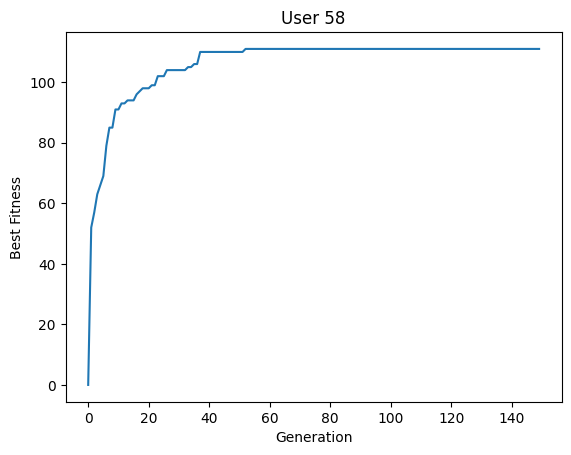

User 59 should buy discs [6, 10, 14, 18, 19, 26, 28, 30, 37, 39, 40, 43, 53, 56, 57, 59, 60, 61, 64, 65, 70, 72, 73, 79, 86, 93, 94, 98]


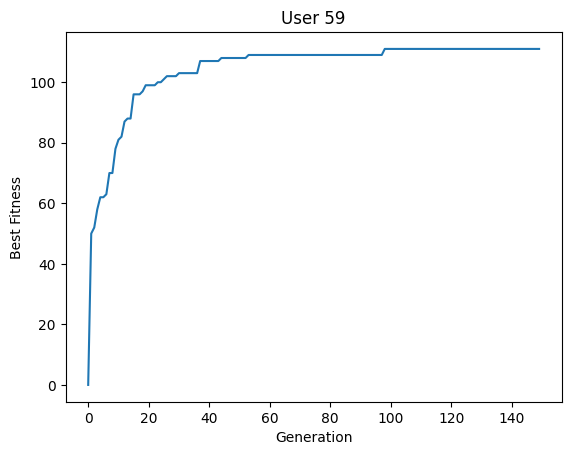

User 60 should buy discs [4, 6, 7, 10, 14, 18, 19, 22, 23, 30, 39, 40, 43, 53, 56, 60, 61, 70, 71, 72, 73, 74, 86, 93, 94, 97, 98]


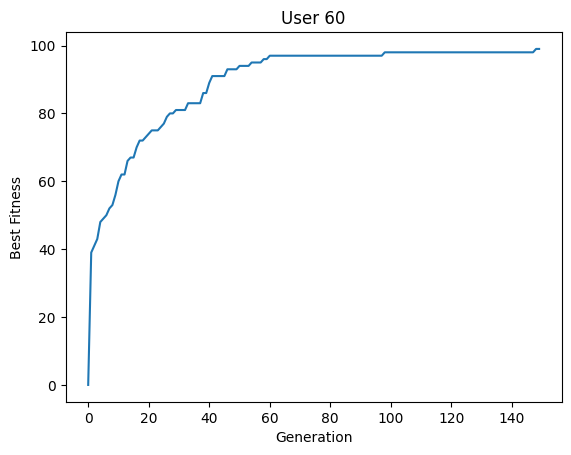

User 61 should buy discs [4, 14, 15, 18, 19, 22, 23, 30, 33, 37, 39, 43, 53, 54, 56, 57, 61, 63, 71, 72, 73, 74, 89, 92, 93, 94, 98]


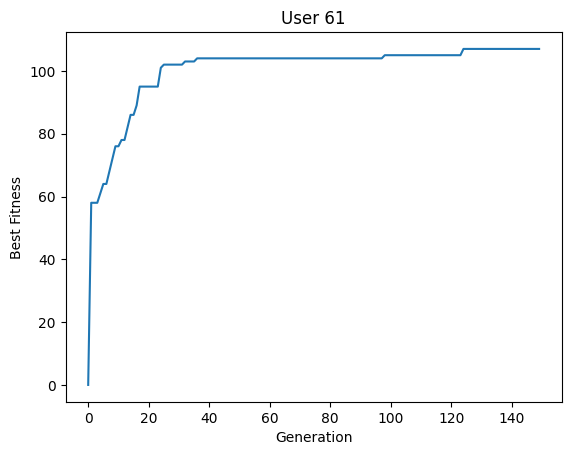

User 62 should buy discs [4, 6, 7, 10, 14, 18, 19, 22, 28, 39, 40, 43, 53, 56, 57, 59, 60, 61, 65, 73, 74, 78, 86, 89, 96, 97, 98]


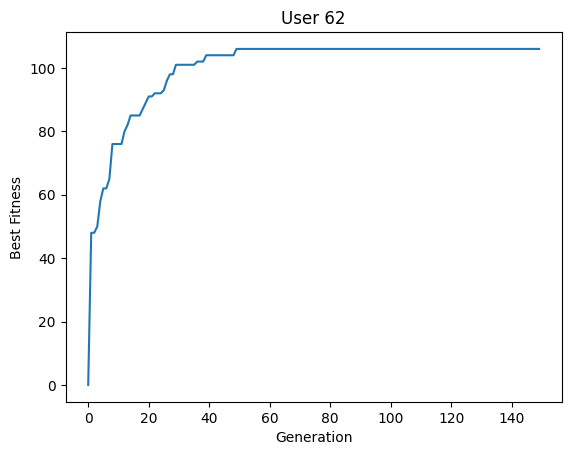

User 63 should buy discs [6, 14, 18, 19, 23, 28, 37, 39, 40, 43, 48, 53, 56, 57, 61, 70, 72, 73, 78, 79, 84, 93, 95, 97, 98]


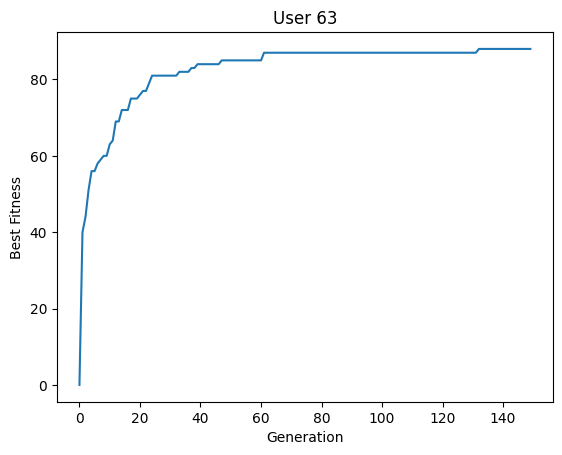

User 64 should buy discs [6, 7, 10, 14, 18, 19, 22, 26, 28, 30, 39, 40, 43, 53, 54, 56, 60, 61, 65, 71, 73, 74, 78, 79, 84, 93, 97]


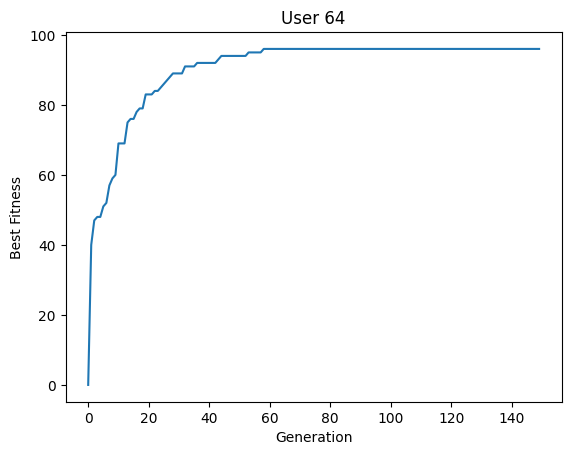

User 65 should buy discs [6, 14, 18, 19, 23, 26, 37, 39, 40, 43, 48, 53, 54, 56, 59, 60, 61, 65, 70, 73, 74, 84, 86, 89, 93, 94, 97, 98]


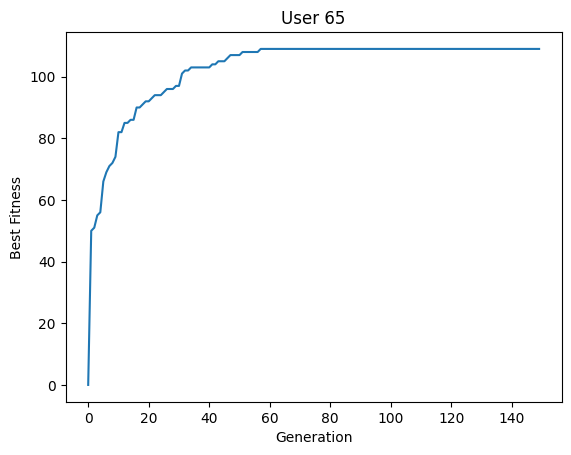

User 66 should buy discs [4, 7, 10, 11, 14, 18, 19, 23, 30, 37, 39, 43, 53, 56, 57, 61, 73, 74, 78, 86, 92, 93, 94, 97, 98]


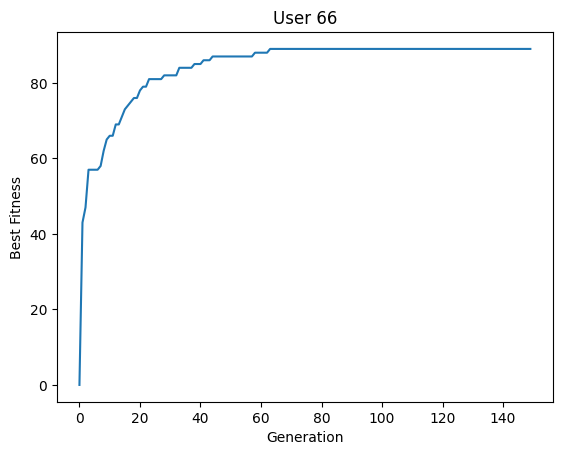

User 67 should buy discs [4, 6, 10, 18, 22, 23, 26, 28, 30, 39, 43, 53, 56, 57, 61, 70, 71, 73, 74, 86, 93, 94, 97, 98]


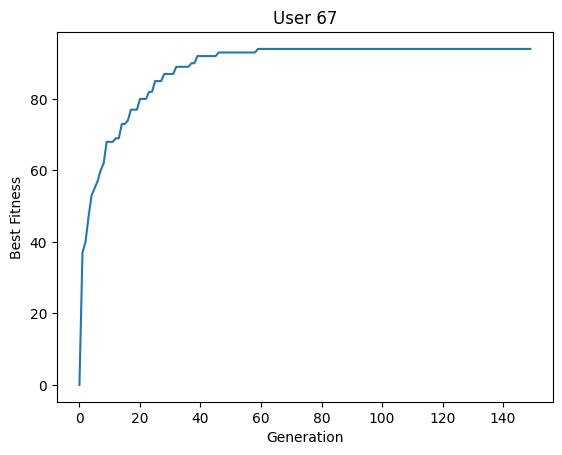

User 68 should buy discs [4, 6, 7, 10, 14, 18, 23, 33, 39, 43, 53, 56, 60, 61, 70, 71, 72, 73, 74, 84, 86, 88, 93, 97, 98]


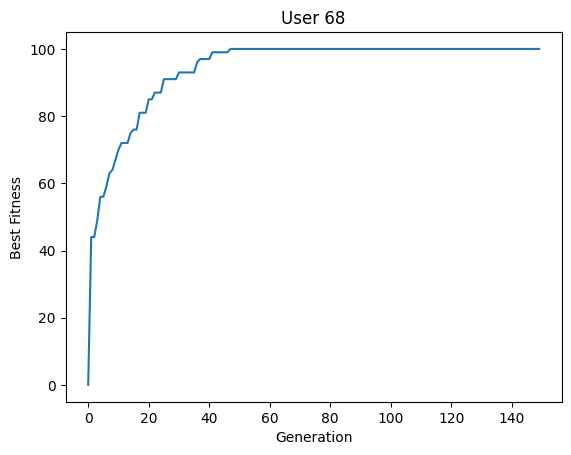

User 69 should buy discs [6, 7, 10, 14, 18, 23, 30, 33, 39, 40, 48, 53, 56, 60, 61, 65, 70, 71, 72, 73, 74, 80, 86, 93, 98]


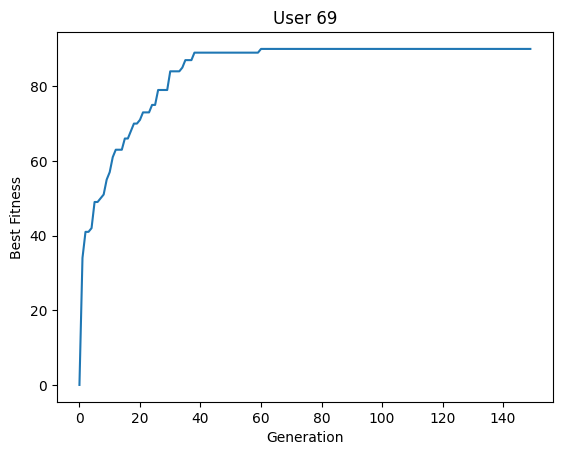

User 70 should buy discs [4, 6, 10, 14, 22, 23, 30, 40, 43, 48, 53, 54, 56, 61, 70, 72, 73, 74, 79, 84, 86, 89, 92, 93, 94, 97, 98]


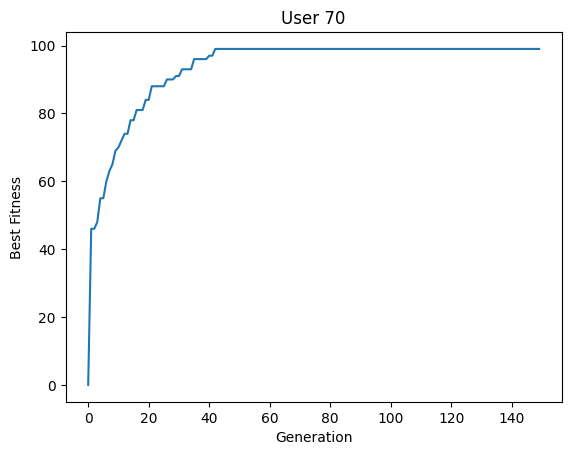

User 71 should buy discs [6, 7, 10, 14, 18, 19, 22, 39, 40, 43, 53, 56, 59, 61, 65, 70, 72, 73, 74, 78, 84, 93, 94, 97, 98]


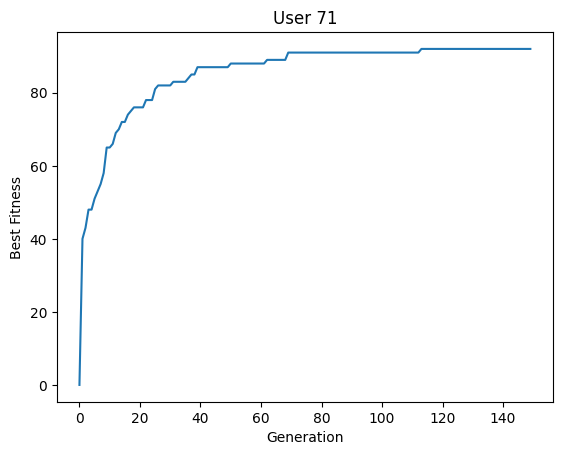

User 72 should buy discs [4, 6, 7, 10, 14, 18, 22, 25, 26, 39, 43, 48, 53, 56, 57, 60, 61, 66, 73, 74, 86, 89, 92, 93, 97, 98]


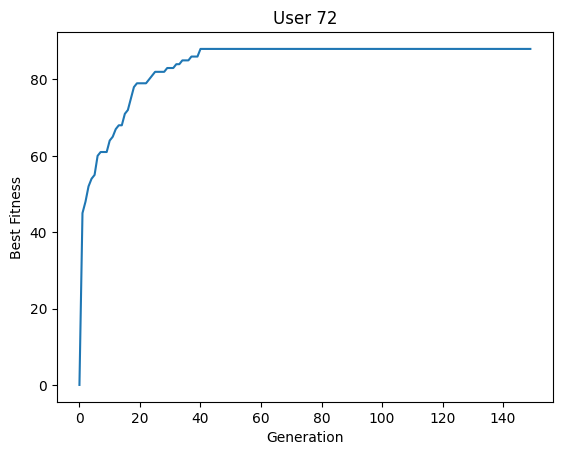

User 73 should buy discs [6, 7, 14, 18, 23, 26, 28, 33, 37, 39, 43, 53, 56, 57, 60, 61, 70, 71, 73, 74, 84, 86, 92, 93, 98]


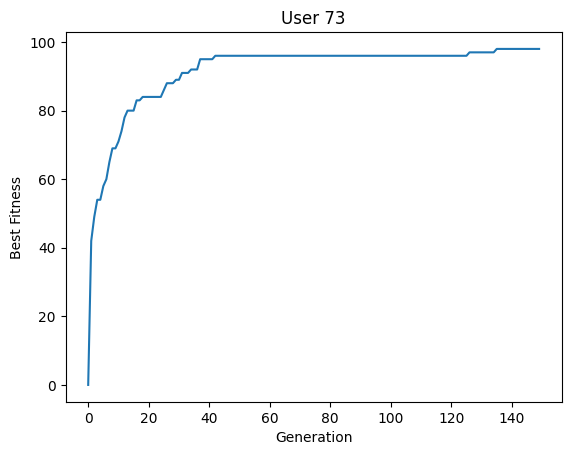

User 74 should buy discs [6, 7, 10, 14, 18, 22, 23, 26, 30, 39, 40, 43, 48, 53, 56, 60, 61, 65, 73, 74, 79, 89, 93, 94, 95, 97, 98]


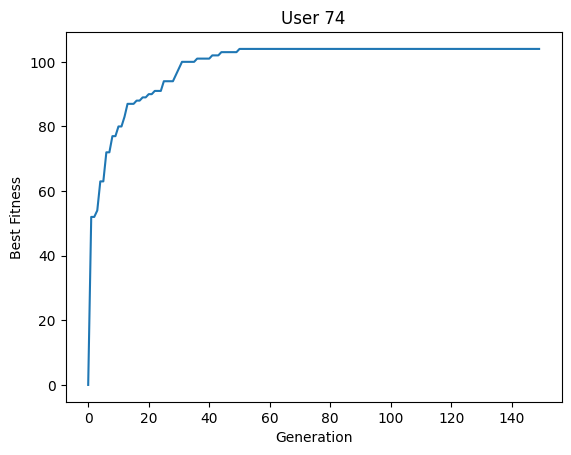

User 75 should buy discs [4, 6, 10, 14, 18, 19, 22, 26, 30, 39, 40, 43, 53, 54, 56, 57, 61, 71, 72, 73, 74, 79, 86, 93, 94, 97, 98]


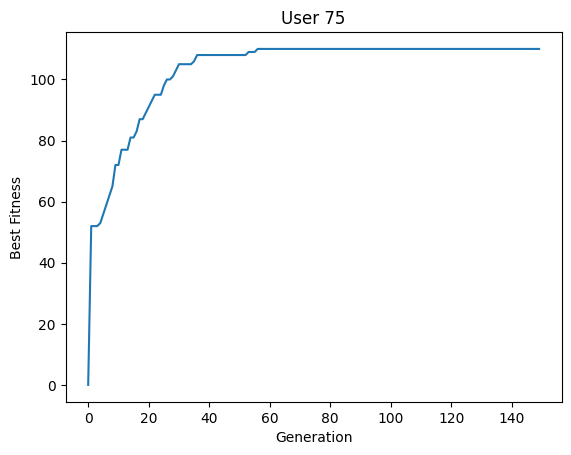

User 76 should buy discs [4, 6, 10, 14, 18, 19, 26, 33, 37, 43, 48, 53, 54, 56, 57, 60, 61, 63, 65, 71, 72, 78, 84, 86, 93, 95, 97, 98]


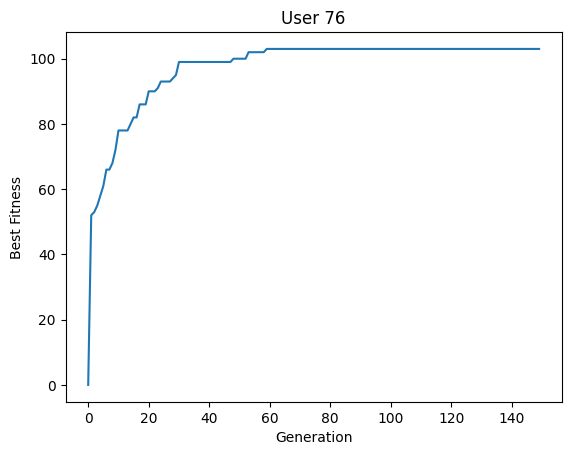

User 77 should buy discs [6, 10, 14, 18, 19, 30, 37, 39, 48, 53, 54, 56, 60, 61, 65, 70, 71, 72, 73, 78, 84, 86, 88, 89, 93, 94, 97, 98]


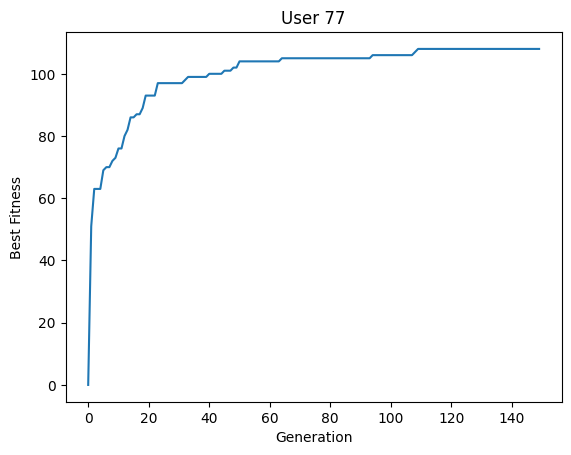

User 78 should buy discs [7, 10, 14, 17, 18, 22, 23, 28, 30, 33, 39, 43, 48, 53, 56, 59, 61, 65, 70, 72, 73, 74, 93, 95, 97, 98]


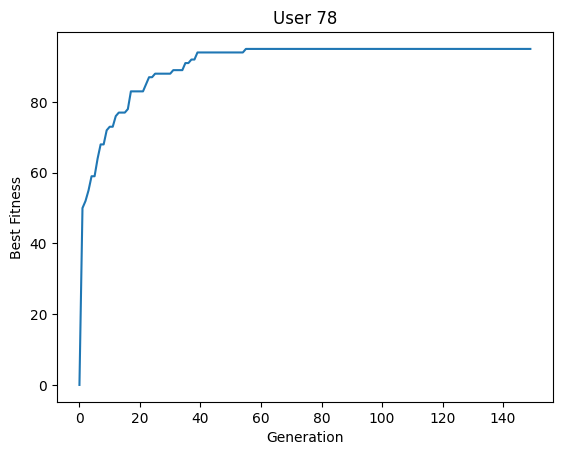

User 79 should buy discs [6, 10, 14, 18, 19, 22, 23, 33, 39, 40, 43, 53, 56, 61, 71, 72, 73, 74, 78, 79, 84, 86, 93, 94, 95, 97, 98]


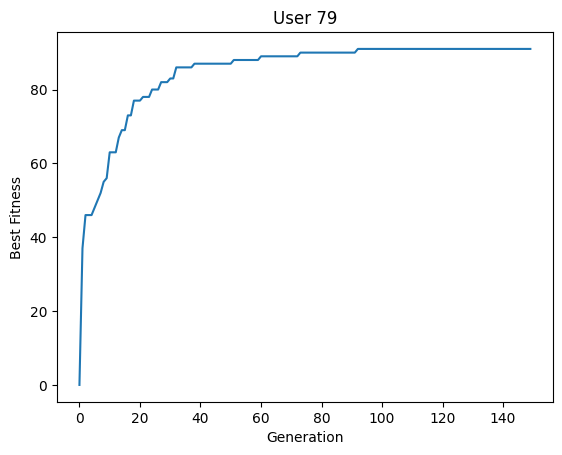

User 80 should buy discs [7, 10, 14, 17, 18, 19, 22, 26, 28, 39, 40, 48, 53, 54, 56, 60, 65, 71, 73, 74, 78, 86, 88, 92, 93, 94, 97, 98]


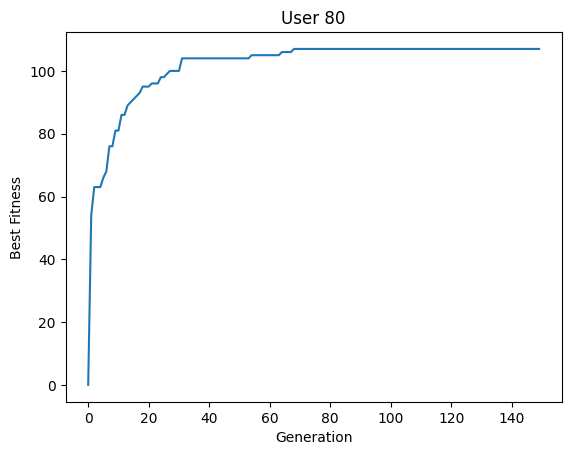

User 81 should buy discs [14, 18, 19, 22, 28, 30, 37, 39, 43, 48, 53, 56, 59, 61, 65, 70, 73, 74, 84, 86, 93, 94, 98]


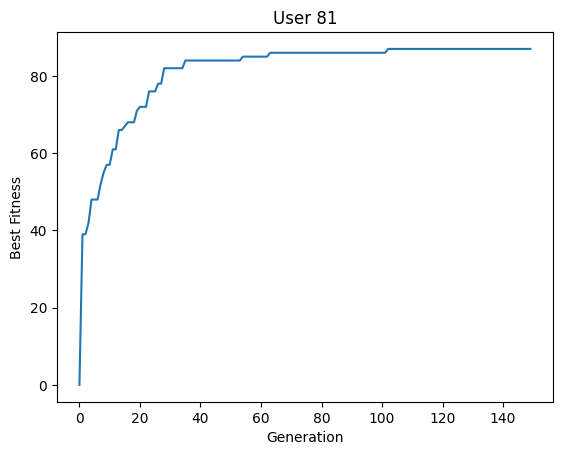

User 82 should buy discs [6, 7, 14, 18, 19, 22, 23, 30, 39, 43, 53, 56, 57, 60, 61, 71, 72, 74, 78, 86, 89, 92, 93, 94, 97, 98]


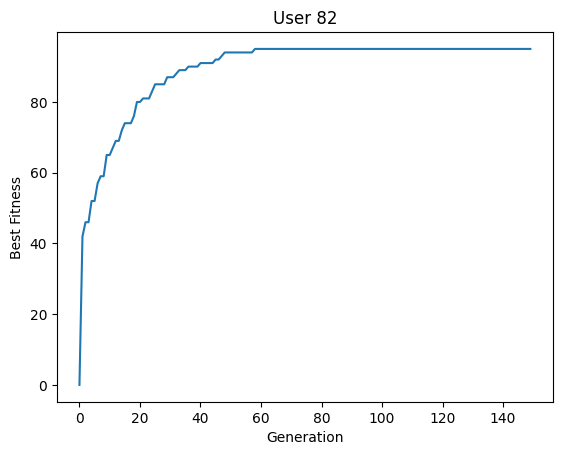

User 83 should buy discs [4, 6, 7, 10, 14, 18, 19, 28, 37, 39, 40, 41, 43, 53, 54, 56, 60, 61, 70, 71, 72, 73, 74, 86, 92, 93, 94, 96, 97, 98]


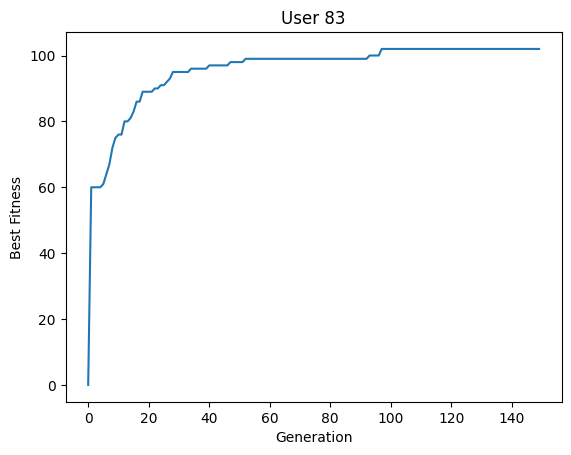

User 84 should buy discs [4, 6, 10, 14, 18, 19, 22, 28, 40, 43, 49, 53, 54, 56, 57, 59, 60, 61, 70, 73, 74, 84, 88, 89, 93, 96, 97, 98]


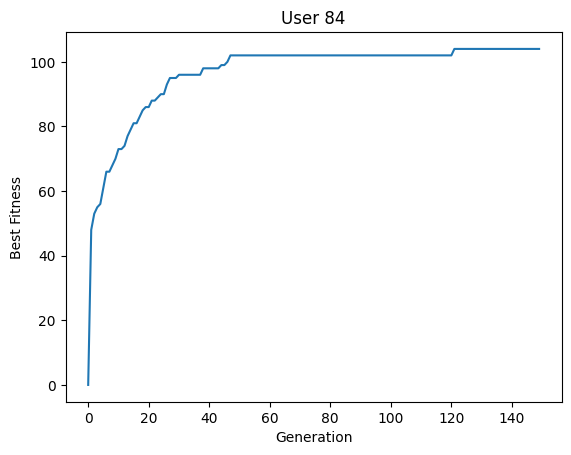

User 85 should buy discs [6, 7, 10, 12, 14, 17, 18, 19, 28, 30, 39, 40, 43, 53, 56, 60, 71, 72, 73, 74, 86, 92, 93, 94, 95, 96, 97, 98]


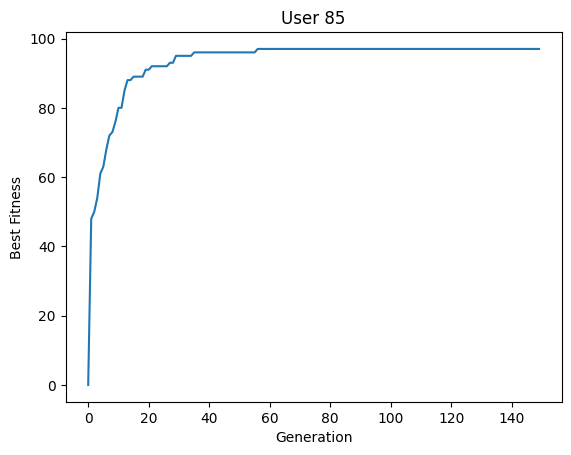

User 86 should buy discs [4, 6, 10, 14, 18, 22, 23, 25, 28, 39, 40, 43, 53, 56, 57, 59, 61, 68, 70, 71, 72, 73, 74, 93, 97, 98]


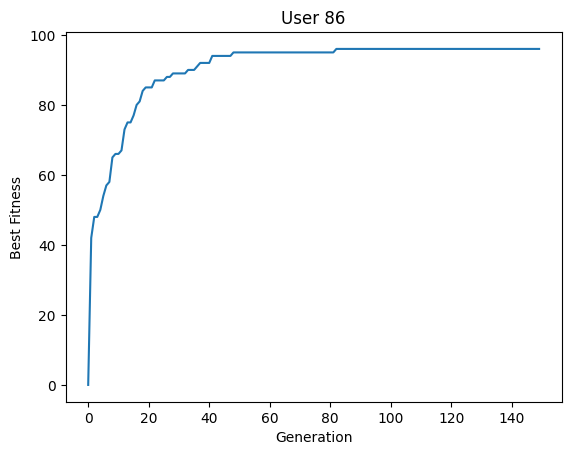

User 87 should buy discs [4, 6, 7, 10, 14, 18, 19, 22, 23, 28, 39, 48, 53, 54, 56, 59, 61, 71, 72, 73, 74, 93, 94, 97, 98]


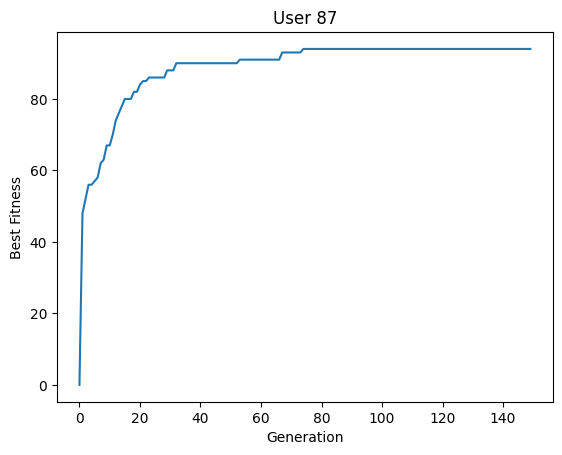

User 88 should buy discs [4, 6, 7, 14, 18, 19, 22, 28, 39, 40, 43, 48, 53, 56, 59, 61, 70, 71, 72, 73, 78, 86, 93, 97, 98]


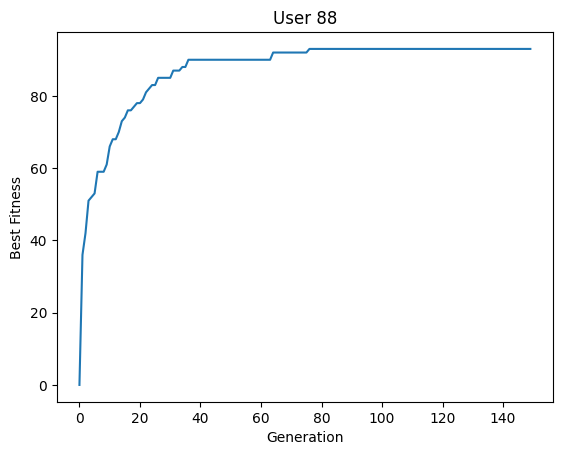

User 89 should buy discs [6, 7, 10, 12, 14, 18, 30, 37, 48, 53, 54, 56, 59, 61, 65, 70, 72, 73, 74, 78, 84, 86, 93, 98]


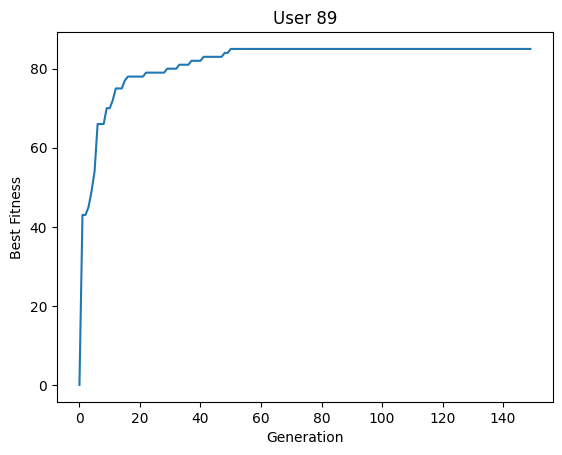

User 90 should buy discs [6, 7, 14, 18, 19, 22, 26, 28, 39, 40, 43, 54, 56, 59, 60, 61, 71, 73, 74, 78, 79, 86, 89, 93, 98]


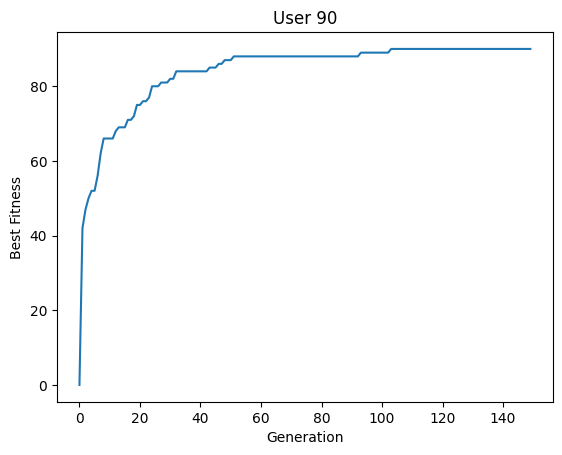

User 91 should buy discs [4, 6, 7, 14, 18, 33, 36, 39, 40, 41, 53, 56, 61, 65, 70, 71, 72, 73, 74, 86, 88, 93, 95, 97]


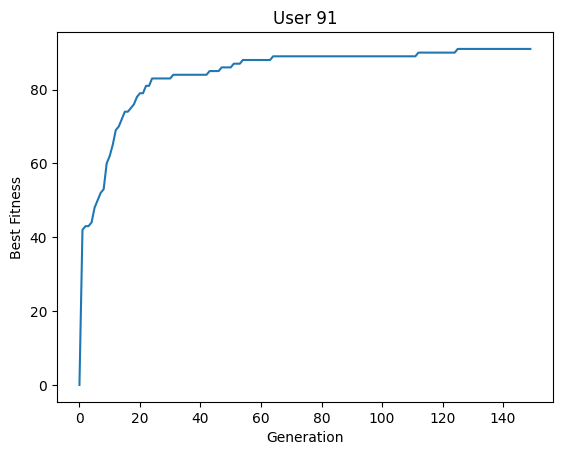

User 92 should buy discs [4, 10, 14, 18, 19, 22, 23, 43, 48, 54, 56, 57, 59, 60, 61, 70, 72, 73, 74, 78, 79, 84, 86, 93, 94, 97, 98]


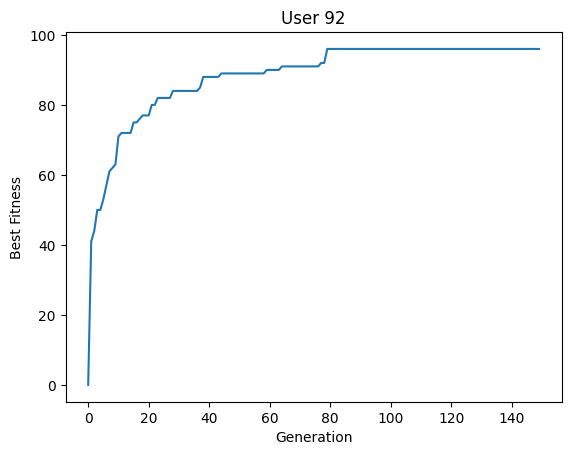

User 93 should buy discs [7, 14, 18, 19, 23, 30, 39, 43, 53, 56, 57, 59, 61, 65, 70, 72, 73, 74, 79, 86, 92, 94, 95]


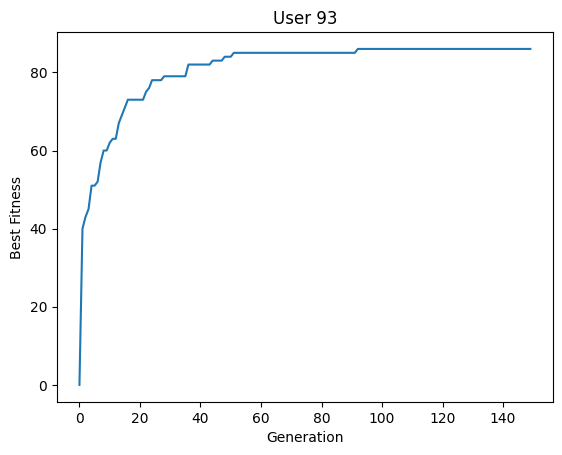

User 94 should buy discs [4, 6, 10, 14, 17, 18, 22, 23, 26, 30, 39, 43, 48, 53, 54, 56, 57, 60, 61, 66, 70, 73, 74, 78, 84, 93, 97, 98]


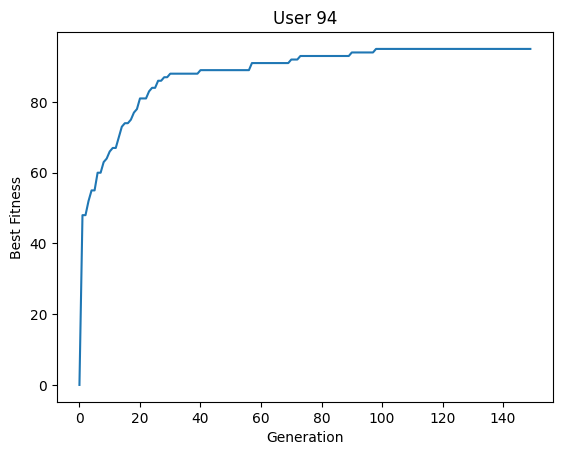

User 95 should buy discs [6, 10, 14, 18, 19, 22, 23, 30, 33, 37, 39, 40, 43, 48, 53, 56, 57, 60, 70, 71, 72, 74, 89, 93, 94, 97, 98]


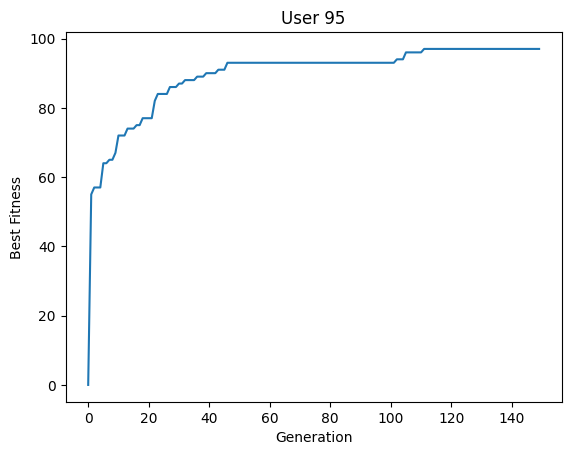

User 96 should buy discs [6, 7, 14, 18, 19, 22, 23, 37, 40, 43, 48, 53, 54, 56, 60, 61, 70, 73, 74, 78, 84, 86, 93, 94, 98]


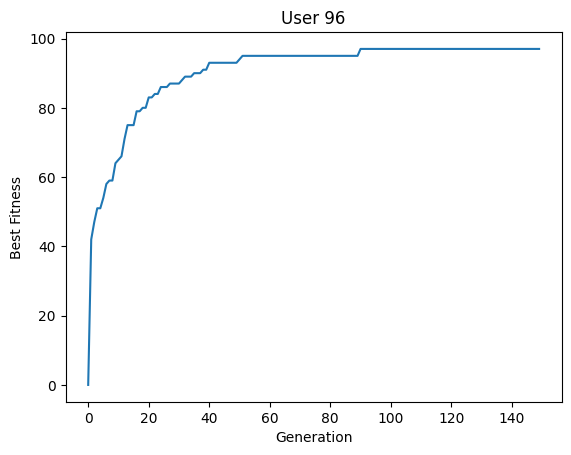

User 97 should buy discs [7, 10, 14, 18, 19, 22, 28, 37, 39, 40, 43, 53, 56, 58, 60, 61, 65, 70, 71, 72, 74, 78, 86, 89, 93, 94, 97]


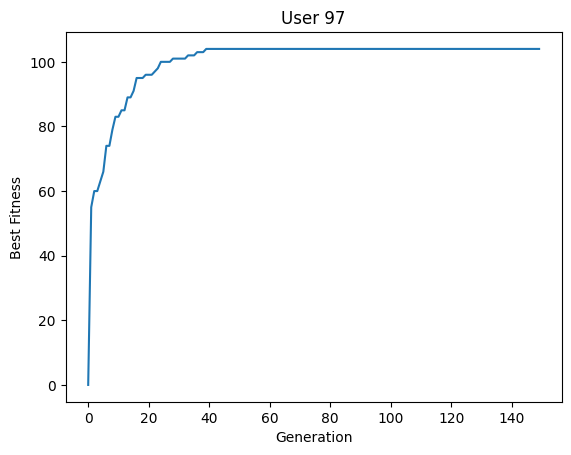

User 98 should buy discs [4, 6, 7, 14, 18, 22, 23, 28, 30, 39, 40, 43, 48, 53, 54, 56, 57, 60, 61, 64, 65, 70, 72, 73, 74, 86, 89, 93, 97, 98]


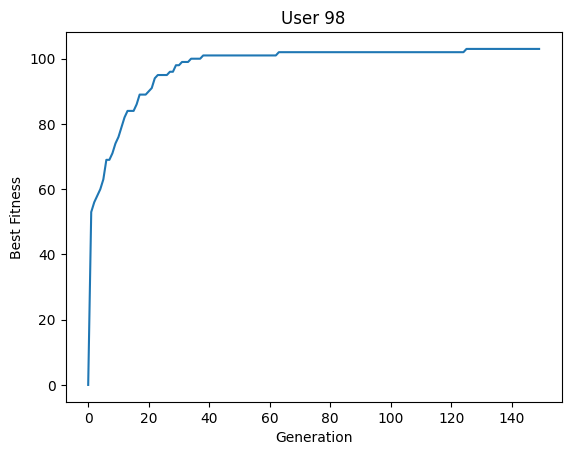

User 99 should buy discs [4, 6, 10, 14, 18, 23, 30, 33, 37, 39, 40, 43, 53, 54, 56, 61, 65, 70, 72, 73, 74, 78, 79, 84, 86, 93, 97, 98]


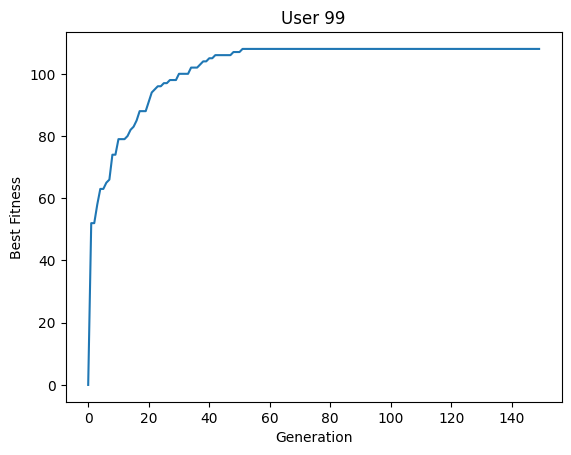

User 100 should buy discs [4, 6, 7, 14, 18, 19, 22, 30, 39, 43, 48, 53, 54, 56, 60, 61, 65, 71, 72, 73, 78, 86, 93, 95, 97, 98]


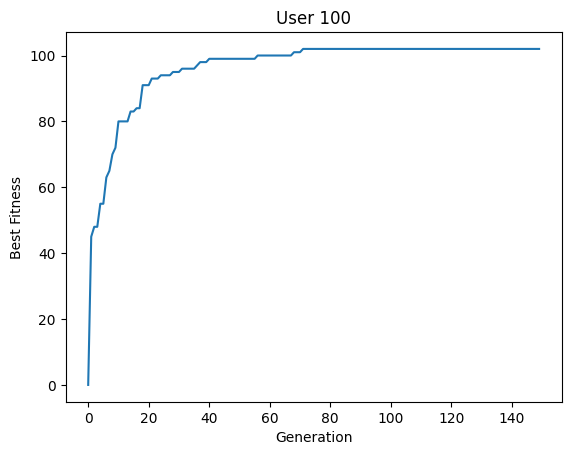

In [ ]:
album_price = album_price.values.flatten()
for i in range(user_money_rates.shape[0]):
    user_money = user_money_rates.iloc[i, 0]
    user_rates = user_money_rates.iloc[i, 1:]
    best_individual, best_fitnesses = genetic_algorithm(100, len(album_price), album_price, user_rates, user_money, elitism_size=8)
    selected_discs = get_selected_discs(best_individual)
    print(f"User {i+1} should buy discs {selected_discs}")

    # Plot the best fitnesses
    plt.figure()
    plt.plot(best_fitnesses)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.title(f'User {i+1}')
    plt.show()

---
Συνοπτικά τα συμπεράσματα μου εφόσον πειραματίσθηκα με την εφαρμογή του γεννετικού αλγορίθμου, ήταν πως τα αποτελέσματα μπορούν να ποικίλουν δραστικά αναλόγως τις τεχνικές ή τα μεγέθη μεταβλητών όπως το population και generations.

Πιο συγκεκριμένα, αρχικά αναπτύχθηκε μια αρκετά απλή έκδοση του γεννετικού αλγορίθμου, με τις βασικές απαραίτητες τεχνικές ώστε να λειτουργεί. Παρατηρήθηκε όμως πως τα αποτελέσματα είχαν σημαντικό περιθώριο βελτίωσης.

Αναλύοντας τα plots έγινε αντιλυπτό πως σε αρκετές περιπτώσεις, εντοπιζόταν μία αρκετά βέλτιστη λύση, πρίν το τελευταίο generation, όπου όταν έφτανε σε αυτό κατέληγε σε μία χειρότερη. Έτσι και έγινε η απόφαση να εφαρμοσθεί η τεχνική elitism. Ο σκοπός ήταν να γίνει σίγουρη η διατήρηση των καλών λύσεων, ώστε να μην χάνονται από γενιά σε γενιά.

Εφόσον αναπτύχθηκε και ο κώδικας για το elitism, τα αποτελέσματα βελτιώθηκαν ραγδαία. Παρόλαυτα ο αριθμός των ελίτ, δεν είναι πάνω από το 10% του γενικού πλυθησμού, ώστε να αποφευχθεί η δυσλειτουργία εύρεσης λύσεων όπως:

*   **Απώλεια διαφορετικότητας** η οποία αντιτίθεται πλήρως της φιλοσοφίας των γενετικών αλγορίθμων, που προσπαθούν να εξερευνούν διαφορετικές περιοχές στον χώρο λύσης
* **Πρόωρη σύγκλιση** ή αλλιώς παδίγευση του γενετικού αλγορίθμου σε μια υποβέλτιστη λύση ή ανεπάρκεια εξερεύνησης καλύτερων λύσεων.
* **Πιο αργή σύγκλιση** δηλαδή το γεγονός πως ένα πιθανόν μεγάλο μέγεθος ελιτισμού μπορεί να αποβεί σε περιορισμένο αριθμό πληθυσμού που υποβάλλεται σε γενετικές "επεμβάσεις" οδηγόντας σε επιβράνδυση του γενετικού αλγορίθμου και κατά συνέχεια σε αδυναμία εύρεσης κατάλληλων λύσεων.
* **Υπολογιστικό κόστος** το οποίο ίσως προκληθεί από την επιλογή και αποθήκευση των καλύτερων "ατόμων", που γίνεται και ιδιαίτερο προβληματικό εάν το μέγεθος του πληθυσμού είναι ήδη μεγάλο.

Είναι σημαντικό να επιτευχθεί μια ισορροπία με το μέγεθος του ελιτισμού. Ενώ η διατήρηση των καλύτερων ατόμων μπορεί να βοηθήσει στη διατήρηση καλών λύσεων, ένα πολύ μεγάλο μέγεθος ελιτισμού μπορεί να έχει αρνητικές επιπτώσεις στην ποικιλομορφία, την εξερεύνηση, τη σύγκλιση και την υπολογιστική απόδοση. Το κατάλληλο μέγεθος ελιτισμού εξαρτάται από το συγκεκριμένο πρόβλημα και τη δυναμική του πληθυσμού. Στην περίπτωση μας βρέθηκε με λίγο πειραματισμό στα προτεινόμενα πλαίσια 5-10% του πληθυσμού.

---

In [ ]:
greater_counter = 0
equal_counter = 0
lesser_counter = 0

for i in range(user_money_rates.shape[0]):
    user_money = user_money_rates.iloc[i, 0]
    user_rates = user_money_rates.iloc[i, 1:]

    # Genetic algorithm.
    best_individual, best_fitnesses = genetic_algorithm(100, len(album_price), album_price, user_rates, user_money, elitism_size=8)
    ga_value = np.sum(best_individual * user_rates)
    ga_cost = np.sum(best_individual * album_price)
    ga_selected_discs = get_selected_discs(best_individual)

    # Greedy selection.
    greedy_individual = greedy_selection(len(album_price), album_price, user_rates, user_money)
    greedy_value = np.sum(greedy_individual * user_rates)
    greedy_cost = np.sum(greedy_individual * album_price)
    greedy_selected_discs = get_selected_discs(greedy_individual)

    print(f"User {i+1}:")
    print(f"  GA: value = {ga_value}, cost = {ga_cost}, discs = {ga_selected_discs}")
    print(f"  Greedy: value = {greedy_value}, cost = {greedy_cost}, discs = {greedy_selected_discs}")

    if ga_value > greedy_value:
        greater_counter += 1
    elif ga_value == greedy_value:
        equal_counter += 1
    else:
        lesser_counter += 1

print("Comparison Counts:")
print(f"GA value > Greedy value: {greater_counter} times")
print(f"GA value = Greedy value: {equal_counter} times")
print(f"GA value < Greedy value: {lesser_counter} times")

User 1:
  GA: value = 97.0, cost = 229.0, discs = [6, 7, 10, 14, 18, 19, 22, 23, 28, 30, 39, 40, 43, 48, 53, 56, 57, 60, 61, 71, 73, 74, 79, 84, 93, 97, 98]
  Greedy: value = 97.0, cost = 229.0, discs = [6, 7, 10, 14, 18, 19, 22, 23, 28, 30, 39, 40, 43, 48, 53, 56, 57, 60, 61, 71, 73, 74, 79, 84, 93, 97, 98]
User 2:
  GA: value = 104.0, cost = 238.0, discs = [4, 6, 7, 10, 14, 18, 19, 22, 23, 28, 30, 33, 39, 43, 53, 56, 60, 61, 70, 71, 72, 73, 74, 78, 79, 93, 97, 98]
  Greedy: value = 105.0, cost = 239.0, discs = [4, 6, 7, 10, 14, 18, 19, 22, 23, 28, 30, 33, 39, 40, 43, 53, 56, 60, 61, 70, 72, 73, 74, 78, 79, 93, 97, 98]
User 3:
  GA: value = 101.0, cost = 244.0, discs = [4, 6, 7, 10, 14, 18, 22, 30, 33, 37, 39, 41, 43, 53, 54, 56, 57, 60, 70, 73, 74, 92, 93, 94, 97, 98]
  Greedy: value = 102.0, cost = 241.0, discs = [4, 6, 7, 10, 14, 18, 19, 22, 30, 33, 37, 39, 43, 48, 53, 54, 56, 57, 60, 61, 70, 73, 74, 92, 93, 94, 97, 98]
User 4:
  GA: value = 110.0, cost = 294.0, discs = [4, 6, 7, 1

---
Παραπάνω βλέπουμε τα αποτελέσματα σύγκρισης του γενετικού αλγορίθμου με τον greedy selection algorithm.

- Ο γενετικός αλγόριθμος ξεπέρασε τον greedy **6 φορές**, ήταν ισάξιοι **30 φορές,** ενώ είχε χαμηλότερη απόδοση (αν και κατά μικρό ποσοστό) **64 φορές.**

- Ο άπληστος αλγόριθμος είναι προφανώς μια α**πλή προσέγγιση** που κάνει την τοπικά βέλτιστη επιλογή σε κάθε στάδιο με την ελπίδα να βρεθεί το συνολικό βέλτιστο.

- Ο γενετικός αλγόριθμος, από την άλλη πλευρά, είναι μια πιο **σύνθετη προσέγγιση** που χρησιμοποιεί μηχανισμούς εμπνευσμένους από τη βιολογική εξέλιξη, όπως η **επιλογή (selection), η διασταύρωση (crossover) και η μετάλλαξη (mutation). **
Είναι ένας "παγκόσμιος" αλγόριθμος βελτιστοποίησης και έχει τη δυνατότητα να βρει τη **γενικά βέλτιση λύση** δεδομένου πως του έχει παραχωρηθεί **αρκετός χρόνος και υπολογιστικοί πόροι.** Ωστόσο, είναι επίσης ένας **στοχαστικός αλγόριθμος,** που σημαίνει ότι μπορεί να δώσει **διαφορετικά αποτελέσματα σε διαφορετικές εκτελέσεις και δεν είναι εγγυημένο ότι θα βρει το συνολικό βέλτιστο.**

- Το γεγονός ότι το GA ξεπέρασε τον αλγόριθμο greedy σε ορισμένες περιπτώσεις υποδηλώνει ότι το GA ήταν σε θέση να βρει κ**αλύτερες λύσεις** που **έχασε ο άπληστος αλγόριθμος**. Ωστόσο, το γεγονός ότι το GA είχε **χαμηλότερη απόδοση** από τον αλγόριθμο greedy στις **περισσότερες περιπτώσεις** υποδηλώνει ότι το GA μπορεί να χρειάζεται **περισσότερο χρόνο ή μεγαλύτερο πληθυσμό** για να βρει καλύτερες λύσεις ή μπορεί να χρειάζεται κάποια ρύθμιση παραμέτρων.

- Μετά από αρκετό πειραματισμό σχετικά με τις παραμέτρους, καταλήξαμε σε έναν συνδιασμό που κατέυθασε ένα **πλατό**. Ακόμα και με εξαιρετικά μεγάλο αριθμό population/generations, το αποτέλεσμα είτε παρέμενε **ίδιο, ή είχε εξαιρετικά ελάχιστη θετική απόδοση.**

- Καθώς αυξάνεται το μέγεθος του πληθυσμού ή τον αριθμό των γενεών, ο αλγόριθμος έχει περισσότερες ευκαιρίες να εξερευνήσει τον χώρο λύσεων και ενδεχομένως να βρει καλύτερες λύσεις. Ωστόσο, αυτό αυξάνει επίσης τον υπολογιστικό χρόνο επειδή ο αλγόριθμος πρέπει να αξιολογήσει περισσότερα άτομα ή να τρέξει για περισσότερες γενιές. Αυτό σχετίζεται με την έννοια της «φθίνουσας απόδοσης» όπως είχε καλυφθεί και στις διαλέξεις.

- Για αυτό είναι και κρίσιμο, με βάση τις ανάγκες του προβλήματος, να επιλέξουμε το μέγεθος του πληθυσμού και τον αριθμό των γενεών με βάση τον χρόνο και τους υπολογιστικούς πόρους που έχουμε διαθέσιμους, καθώς και την πολυπλοκότητα του προβλήματος.

- Επιπλέον μπορούμε  να χρησιμοποιήσουμε τεχνικές όπως παράλληλο υπολογισμό για να καταφέρουμε **επιτάχυνση των υπολογισμών.**

Συνεχίζοντας όμως, στις τεχνικές που χρησιμοποιήθηκαν:

- Η εφαρμογή διαφορετικών τεχνικών, όπως ο **"ελιτισμός"** και **επιλογή "tournament"**, προσέφεραν εξαιρετική βελτίωση. Παρόλαυτα, το αποτέλεσμα ήταν το παραπάνω. Φυσικά αυτό δεν είναι απαραίτητα κάποιο αρνητικό "νέο", καθώς αξίζει να σημειωθεί ότι το GA και ο αλγόριθμος greedy έχουν **διαφορετικά πλεονεκτήματα και αδυναμίες** και ο καλύτερος αλγόριθμος για χρήση μπορεί να εξαρτάται από το **συγκεκριμένο πρόβλημα και τους περιορισμούς.**
-Για παράδειγμα, **το GA** μπορεί να είναι πιο **κατάλληλο** για προβλήματα όπου **ο χώρος αναζήτησης είναι μεγάλος και πολύπλοκος** και είναι σημαντικό να βρεθεί το **συνολικό βέλτιστο.**

- **Ο άπληστος αλγόριθμος**, από την άλλη πλευρά, μπορεί να είναι πιο **κατάλληλος** για προβλήματα όπου ο χώρος αναζήτησης είναι μικρότερος ή απλούστερος ή όπου είναι πιο σημαντικό να βρεθεί μια **καλή λύση γρήγορα.**

Συμπερασματικά, αυτά τα αποτελέσματα παρέχουν **πολύτιμες πληροφορίες** σχετικά με την απόδοση του GA και τον άπληστο αλγόριθμο στο πρόβλημά μας και μπορούν να μας καθοδηγήσουν στην περαιτέρω βελτίωση της προσέγγισής μας και στην επιλογή του **καλύτερου αλγόριθμου για τις ανάγκες μας.**

Καταλήγοντας γενικότερα, μου έγινε αντιλυπτό το πολύπτυχο φαινόμενο του γενετικού αλγοριθμού, και μου κεντρίστηκε το ενδιαφέρον στην πολυπλοκότητα αυτής της τεχνολογίας. Είναι αξιοσημείωτο πως από μια φυσική λειτουργία αληθινών ζωντανών οργανισμών που επιτελείται επί εκατομμύρια χρόνια, οι άνθρωποι εμπνευστίκαμε για άλλη μια φορά από την φύση και μετατρέψαμε μια βιολογική διαδικασία σε θεωρία και τεχνολογία επίλυσης υπολογιστηκών προβλημάτων.

---